# Main Notebook

File to perform experiments

## Imports

In [1]:
import os
import numpy as np
import gpflow
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import tensorflow as tf

from models.GaussianProcess import GaussianProcess
from acquisition_functions.UseMO import usemo_acq
from acquisition_functions.MES import mes_acq, basic_mes_acq
from acquisition_functions.PESMO import pesmo_acq
from acquisition_functions.MESMO import mesmo_acq
from arguments.arguments import MainArguments

from MOObenchmark import MOOackley, MOOexponential, MOOquadratic_ackley, MOOnnHousesRegressionMixedProb
from utils.calc_pareto import get_pareto_undominated_by, getSetfromFront

from models.MOOEvaluationProblem import MOOEvaluationProblem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_termination
from pymoo.optimize import minimize

2023-06-12 23:08:14.396048: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:08:14.436461: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-12 23:08:14.436906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-12 23:08:15.017402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Algorithm Arguments

In [2]:
d = 3 # input dimensions
    
seed = 1
np.random.seed(seed)

## iterations of the main algorithm
total_iter = 100
## iterations taken randomly at the beggining
initial_iter = 1

## bound of the inputs definition
### with the current implementations all the input dimensions must have the same bounds, 
### but this can be changed
lower_bound = 10
upper_bound = 1000

lowerBounds = [lower_bound]*d
upperBounds = [upper_bound]*d


## Evaluation

In [3]:
## Evaluation function definition
O = 2
C = 0

def evaluation(x):
    return MOOnnHousesRegressionMixedProb(x)

This cell below gets the real pareto in two ways: with a grid and with a cheap optimizer (genetic algorithm) and plots both of them. These results are used in test problems as the actual pareto front. Although, to obtain these paretos many evaluations of the function are needed, so it has no sense running it in a costly black box problem.

In addition this is only prepared to plot a d=1, O=2 problem. We could visualize any problem, but the visualization get a lot more abstract and more plots are needed. If this is interesting I could do it.

Therefore I set the code below as text.

N = 1_001
X = np.linspace(lower_bound,upper_bound,N)
Z = np.zeros((N,2))

problem = MOOEvaluationProblem(evaluation, O=O, d=d, lowerBounds=lower_bound, upperBounds=upper_bound)
algorithm = NSGA2()
res = minimize( problem, 
                algorithm,
                termination = get_termination("n_gen",100))

real_pareto = res.F[np.argsort(res.F[:,0])]

for i in range(N):
    Z[i]=evaluation(X[i])

fig, axs = plt.subplots(1,3, figsize=(15,4))

axs[0].plot(X, Z[:,0], 'b')
axs[0].plot(X, Z[:,1], 'k')
axs[0].plot(res.X, res.F[:,0], 'xr', markersize=5)
axs[0].plot(res.X, res.F[:,1], 'xr', markersize=5)

axs[1].plot(np.reshape(Z,(-1,2))[:,0], np.reshape(Z,(-1,2))[:,1], 'kx')
axs[1].plot(res.F[:,0], res.F[:,1], 'rx')
res
axs[2].plot(res.F[:,0], res.F[:,1], 'x')
plt.show()

In [4]:
def random_acq(GP: GaussianProcess, **kwargs):
    while True:
        x_rand = np.random.uniform(GP.lowerBounds, GP.upperBounds, GP.d)
        if GP.X is None or not x_rand in GP.X:
            break
    return x_rand, 0

## N experiments

C = [423, 723, 0.005056615534585719]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 573849024.0000 - mae: 211586.2500 - mse: 113442947072.0000 - val_loss: 343586944.0000 - val_mae: 162902.3750 - val_mse: 67915776000.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 312917888.0000 - mae: 164337.9531 - mse: 61850353664.0000 - val_loss: 302712224.0000 - val_mae: 171570.8594 - val_mse: 59830657024.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 294870656.0000 - mae: 160782.1406 - mse: 58282012672.0000 - val_loss: 271007424.0000 - val_mae: 154358.4531 - val_mse: 53564080128.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 289355008.0000 - mae: 158491.7812 - mse: 57191673856.0000 - val_loss: 277925120.0000 - val_mae: 161309.7969 - val_mse: 54930771968.0000
Epoch 5/6
517/517 [==============================] - 1s 3ms/step - loss: 286680768.0000 - mae: 157804.3281 - mse: 56663031808.

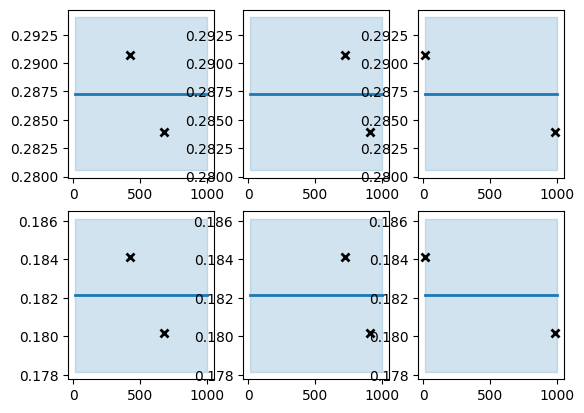

x_best =  [769.11877238  45.6060736  976.63651047]
acq_best =  [0.00134245 0.00079004]
C = [769, 46, 0.48831825523720485]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 59874455552.0000 - mae: 221625.5781 - mse: 122613071872.0000 - val_loss: 37731229696.0000 - val_mae: 173818.2812 - val_mse: 77267320832.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 31997667328.0000 - mae: 166924.3594 - mse: 65525927936.0000 - val_loss: 27482189824.0000 - val_mae: 159371.7656 - val_mse: 56278933504.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 28906948608.0000 - mae: 161283.6719 - mse: 59196657664.0000 - val_loss: 26647252992.0000 - val_mae: 154511.9688 - val_mse: 54569123840.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 28236969984.0000 - mae: 159533.2969 - mse: 57824579584.0000 - val_loss: 27878785024.0000 - val_mae: 155700.2969 - val_mse: 57091100672.0000
Epoch 5/6
517/517 [======

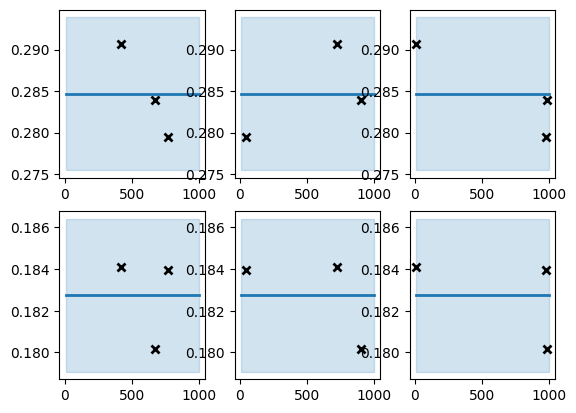

x_best =  [ 84.45099705 221.06939122 524.22637469]
acq_best =  [0.00183771 0.00073119]
C = [85, 221, 0.26211318734264644]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 36712189952.0000 - mae: 240217.1406 - mse: 140061376512.0000 - val_loss: 31099803648.0000 - val_mae: 220987.4219 - val_mse: 118649430016.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 26074394624.0000 - mae: 198479.2812 - mse: 99476946944.0000 - val_loss: 18489868288.0000 - val_mae: 165485.9219 - val_mse: 70540935168.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 16732163072.0000 - mae: 163964.3594 - mse: 63834951680.0000 - val_loss: 17763147776.0000 - val_mae: 180696.1719 - val_mse: 67768291328.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 15578725376.0000 - mae: 161085.2812 - mse: 59434479616.0000 - val_loss: 14617054208.0000 - val_mae: 157303.1562 - val_mse: 55765590016.0000
Epoch 5/6
517/517 [=====

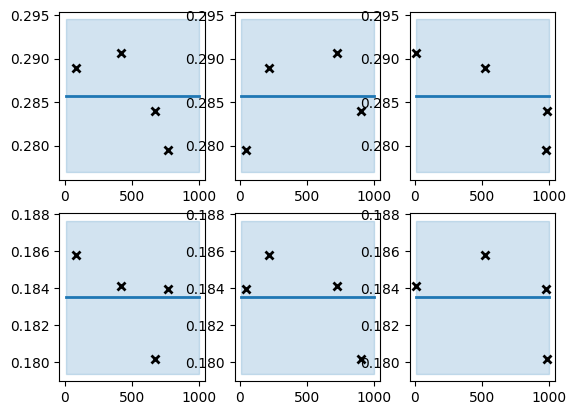

x_best =  [767.14409204 812.13948933 463.07404419]
acq_best =  [0.00175357 0.00082333]
C = [767, 812, 0.23153702209487476]
Epoch 1/6
517/517 [==============================] - 3s 6ms/step - loss: 23693461504.0000 - mae: 202497.4844 - mse: 102330318848.0000 - val_loss: 13824333824.0000 - val_mae: 163329.6719 - val_mse: 59706093568.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 14166200320.0000 - mae: 163967.8125 - mse: 61182578688.0000 - val_loss: 13340488704.0000 - val_mae: 155610.9688 - val_mse: 57616408576.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 13522130944.0000 - mae: 160669.7344 - mse: 58400915456.0000 - val_loss: 13016713216.0000 - val_mae: 155083.4375 - val_mse: 56218046464.0000
Epoch 4/6
517/517 [==============================] - 3s 7ms/step - loss: 13224201216.0000 - mae: 158610.8125 - mse: 57114136576.0000 - val_loss: 13716426752.0000 - val_mae: 155764.7656 - val_mse: 59240075264.0000
Epoch 5/6
517/517 [=====

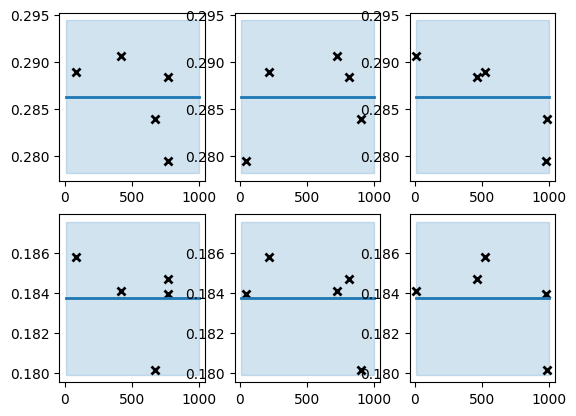

x_best =  [934.99801669 754.69730263 987.83019017]
acq_best =  [0.00162422 0.00076187]
C = [935, 755, 0.4939150950843935]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 208946675712.0000 - mae: 538371.3750 - mse: 423040942080.0000 - val_loss: 212405207040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 7ms/step - loss: 208946790400.0000 - mae: 538371.8125 - mse: 423040581632.0000 - val_loss: 212405207040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 208946642944.0000 - mae: 538371.6250 - mse: 423040745472.0000 - val_loss: 212405207040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 208946692096.0000 - mae: 538371.6250 - mse: 423040516096.0000 - val_loss: 212405207040.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6

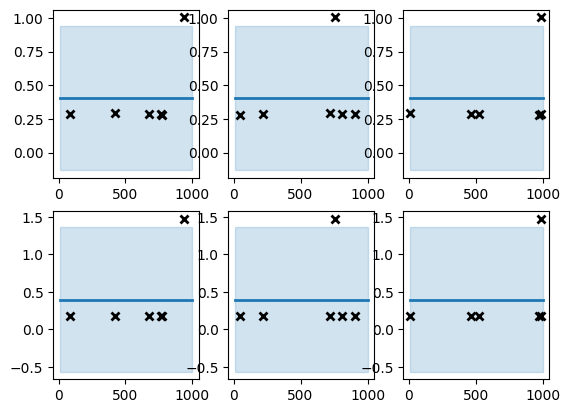

x_best =  [504.46246847 178.06943394 221.80763754]
acq_best =  [0.10683399 0.19187438]
C = [504, 178, 0.11090381876904927]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 46917361664.0000 - mae: 538371.3750 - mse: 423040778240.0000 - val_loss: 47693967360.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 46917365760.0000 - mae: 538371.6250 - mse: 423040778240.0000 - val_loss: 47693967360.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 46917357568.0000 - mae: 538371.4375 - mse: 423040843776.0000 - val_loss: 47693967360.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 46917357568.0000 - mae: 538371.6250 - mse: 423040876544.0000 - val_loss: 47693967360.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517

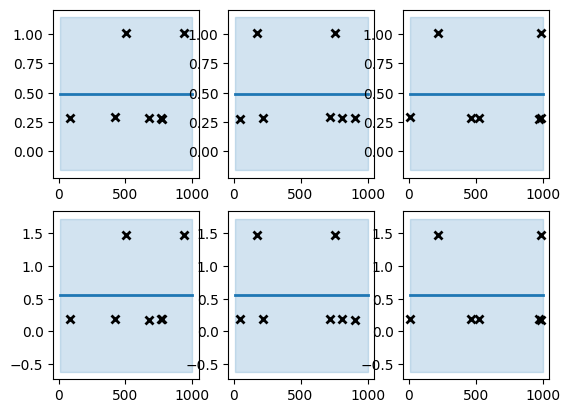

x_best =  [121.4672689  862.98909925  32.81581476]
acq_best =  [0.12949716 0.23258593]
C = [121, 863, 0.016407907380241133]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 6941748224.0000 - mae: 538371.3750 - mse: 423040581632.0000 - val_loss: 7056648192.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 6941750784.0000 - mae: 538371.5625 - mse: 423040647168.0000 - val_loss: 7056648192.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 6941752320.0000 - mae: 538371.3125 - mse: 423040385024.0000 - val_loss: 7056648192.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 6941749760.0000 - mae: 538371.4375 - mse: 423040679936.0000 - val_loss: 7056648192.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [=====

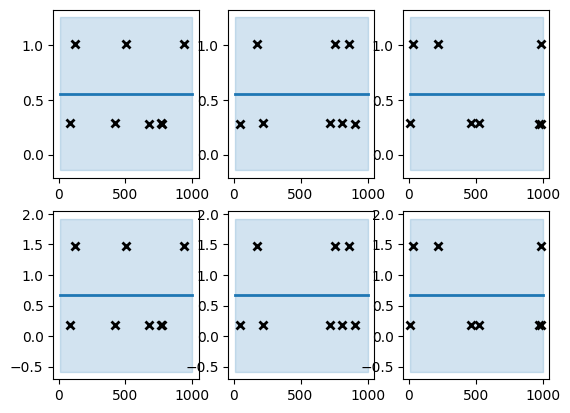

x_best =  [136.05496298 445.04880873 971.69299747]
acq_best =  [0.13877398 0.24925117]
C = [136, 445, 0.48584649873250274]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 63831289856.0000 - mae: 230640.7969 - mse: 131381051392.0000 - val_loss: 51853987840.0000 - val_mae: 213697.9531 - val_mse: 106728783872.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 37620350976.0000 - mae: 176931.2188 - mse: 77432168448.0000 - val_loss: 28940111872.0000 - val_mae: 158090.5625 - val_mse: 59566026752.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 29075222528.0000 - mae: 161674.0000 - mse: 59844116480.0000 - val_loss: 26393536512.0000 - val_mae: 152984.5625 - val_mse: 54324523008.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 28238233600.0000 - mae: 159762.6719 - mse: 58121330688.0000 - val_loss: 25869428736.0000 - val_mae: 153238.4844 - val_mse: 53245788160.0000
Epoch 5/6
517/517 [====

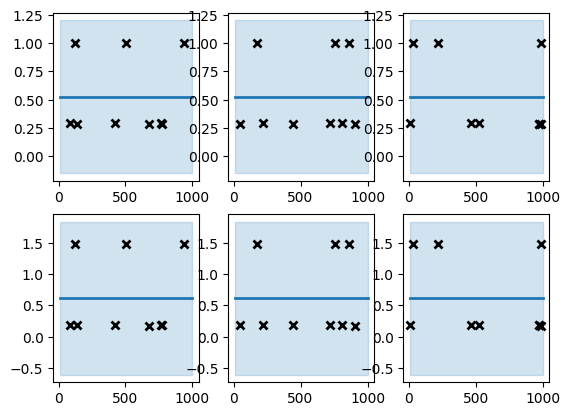

x_best =  [603.14975963 449.96983034 869.74314662]
acq_best =  [0.13514983 0.24263445]
C = [604, 450, 0.4348715733084111]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 47975481344.0000 - mae: 210299.7500 - mse: 110320615424.0000 - val_loss: 26652252160.0000 - val_mae: 158308.7344 - val_mse: 61287272448.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 26690502656.0000 - mae: 164402.1250 - mse: 61375250432.0000 - val_loss: 24028049408.0000 - val_mae: 153257.2656 - val_mse: 55252869120.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 25434765312.0000 - mae: 160990.0156 - mse: 58487640064.0000 - val_loss: 25743056896.0000 - val_mae: 156987.7969 - val_mse: 59196555264.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 25348214784.0000 - mae: 160410.7188 - mse: 58288619520.0000 - val_loss: 23599933440.0000 - val_mae: 152900.9844 - val_mse: 54268379136.0000
Epoch 5/6
517/517 [======

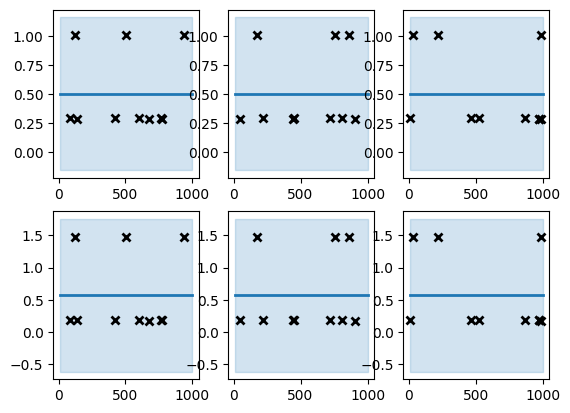

x_best =  [150.11368381 452.01805412 744.66026099]
acq_best =  [0.13133494 0.23583246]
C = [150, 452, 0.3723301304936124]
Epoch 1/6
517/517 [==============================] - 4s 4ms/step - loss: 46749466624.0000 - mae: 223695.6562 - mse: 125558595584.0000 - val_loss: 32382283776.0000 - val_mae: 180010.3438 - val_mse: 86971498496.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 25375145984.0000 - mae: 167529.6719 - mse: 68151836672.0000 - val_loss: 22086625280.0000 - val_mae: 165866.2812 - val_mse: 59319566336.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 22718099456.0000 - mae: 163710.3594 - mse: 61015547904.0000 - val_loss: 21408227328.0000 - val_mae: 165165.2656 - val_mse: 57497530368.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 21852678144.0000 - mae: 160624.9219 - mse: 58691264512.0000 - val_loss: 20282531840.0000 - val_mae: 153359.5000 - val_mse: 54474170368.0000
Epoch 5/6
517/517 [======

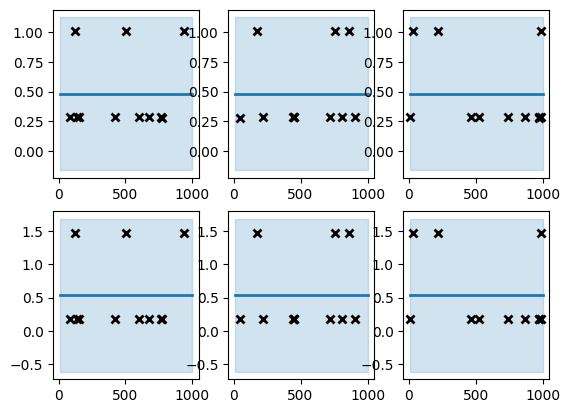

x_best =  [286.34803766  60.37382314 266.90194658]
acq_best =  [0.12771227 0.22925188]
C = [286, 60, 0.13345097328861744]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 18128173056.0000 - mae: 233445.6094 - mse: 135839809536.0000 - val_loss: 14418419712.0000 - val_mae: 199407.1094 - val_mse: 108041363456.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 10291587072.0000 - mae: 175977.3750 - mse: 77117513728.0000 - val_loss: 7897600512.0000 - val_mae: 158325.7344 - val_mse: 59178635264.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 8186872320.0000 - mae: 162825.6562 - mse: 61346172928.0000 - val_loss: 7932034560.0000 - val_mae: 167460.2812 - val_mse: 59436572672.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 7946235392.0000 - mae: 161503.7812 - mse: 59543031808.0000 - val_loss: 7582900736.0000 - val_mae: 165024.0781 - val_mse: 56820396032.0000
Epoch 5/6
517/517 [==========

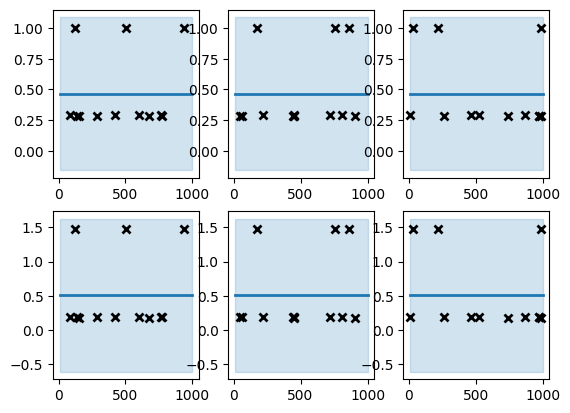

x_best =  [344.84900227 200.96986434  63.01887244]
acq_best =  [0.12421946 0.22269831]
C = [344, 201, 0.03150943622027483]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 4068969472.0000 - mae: 227131.3438 - mse: 129127743488.0000 - val_loss: 2792634880.0000 - val_mae: 195654.2969 - val_mse: 88622301184.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 2132843520.0000 - mae: 167290.5625 - mse: 67683790848.0000 - val_loss: 1807356160.0000 - val_mae: 159022.5312 - val_mse: 57354149888.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 1895403392.0000 - mae: 162788.5312 - mse: 60148367360.0000 - val_loss: 1868285056.0000 - val_mae: 160062.9375 - val_mse: 59287793664.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 1840291328.0000 - mae: 160405.0625 - mse: 58399313920.0000 - val_loss: 1748232448.0000 - val_mae: 160663.4375 - val_mse: 55477710848.0000
Epoch 5/6
517/517 [=============

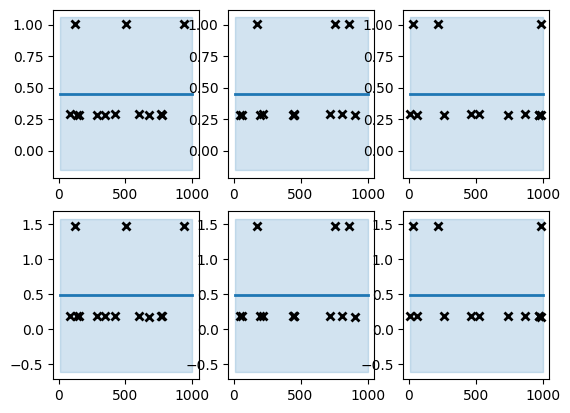

x_best =  [286.35904491  60.43882463 266.91133698]
acq_best =  [-7.81616605e-18 -1.17319533e-17]
C = [287, 61, 0.13345566848842702]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 18432350208.0000 - mae: 236300.6719 - mse: 138114138112.0000 - val_loss: 15267718144.0000 - val_mae: 210868.7031 - val_mse: 114401329152.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 11906770944.0000 - mae: 186935.5156 - mse: 89217523712.0000 - val_loss: 8907157504.0000 - val_mae: 161020.6406 - val_mse: 66741248000.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 8451695104.0000 - mae: 164786.8125 - mse: 63328395264.0000 - val_loss: 7635319808.0000 - val_mae: 157606.2969 - val_mse: 57211219968.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 8094797824.0000 - mae: 161984.6875 - mse: 60654080000.0000 - val_loss: 7730270208.0000 - val_mae: 155946.0625 - val_mse: 57922699264.0000
Epoch 5/6
517/517 [

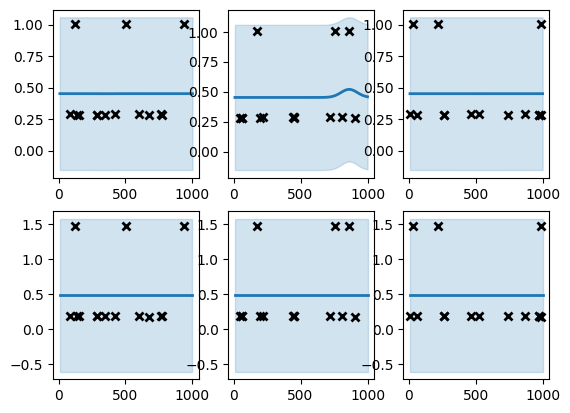

x_best =  [ 87.94465873 221.13585255 526.07172987]
acq_best =  [-8.87299210e-18  1.43838622e-01]
C = [88, 221, 0.263035864937243]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 37259456512.0000 - mae: 241897.2344 - mse: 141650788352.0000 - val_loss: 30050791424.0000 - val_mae: 225637.3906 - val_mse: 114245148672.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 22158364672.0000 - mae: 184192.6562 - mse: 84240121856.0000 - val_loss: 17062140928.0000 - val_mae: 167142.1875 - val_mse: 64865574912.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 16641592320.0000 - mae: 164786.5312 - mse: 63266779136.0000 - val_loss: 15049544704.0000 - val_mae: 157415.0781 - val_mse: 57214210048.0000
Epoch 4/6
517/517 [==============================] - 1s 1ms/step - loss: 15998045184.0000 - mae: 163113.7812 - mse: 60820176896.0000 - val_loss: 15105409024.0000 - val_mae: 158903.7188 - val_mse: 57426591744.0000
Epoch 5/6
517/51

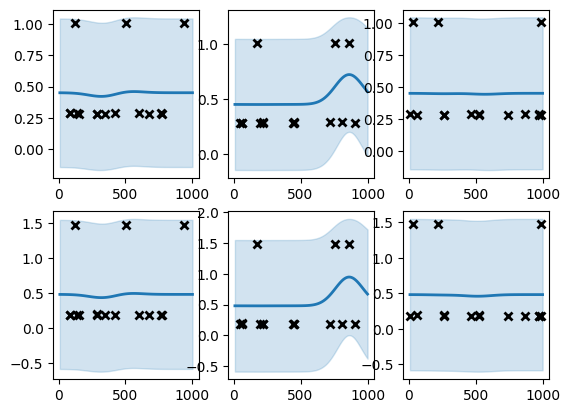

x_best =  [ 93.98044292 226.51844513 523.84426644]
acq_best =  [-9.11390333e-18  1.08910612e-14]
C = [94, 226, 0.26192213321963737]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 35911479296.0000 - mae: 237368.6562 - mse: 137106481152.0000 - val_loss: 30474364928.0000 - val_mae: 222981.5000 - val_mse: 116348108800.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 23642472448.0000 - mae: 187814.9844 - mse: 90264559616.0000 - val_loss: 16762034176.0000 - val_mae: 170189.4219 - val_mse: 63995617280.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 16519531520.0000 - mae: 164611.2812 - mse: 63069765632.0000 - val_loss: 14987655168.0000 - val_mae: 158688.8594 - val_mse: 57221201920.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 15760941056.0000 - mae: 161776.0469 - mse: 60173492224.0000 - val_loss: 14503407616.0000 - val_mae: 154872.7031 - val_mse: 55372394496.0000
Epoch 5/6
517/

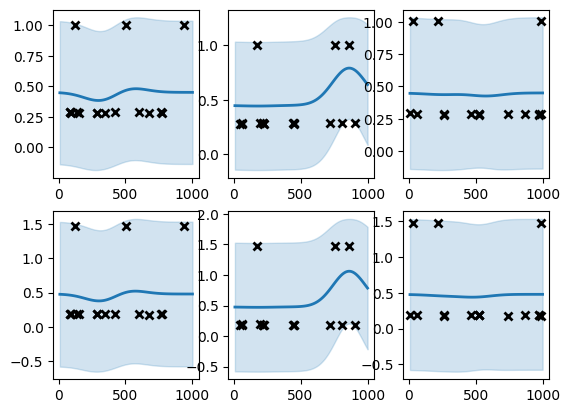

x_best =  [115.15227094 215.06999847 538.04565415]
acq_best =  [-9.97784573e-18  6.22911477e-06]
C = [115, 216, 0.26902282707467756]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 36248039424.0000 - mae: 234467.9375 - mse: 134738796544.0000 - val_loss: 30208073728.0000 - val_mae: 224202.5938 - val_mse: 112287318016.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 22023305216.0000 - mae: 181185.6406 - mse: 81863393280.0000 - val_loss: 16252083200.0000 - val_mae: 168139.9688 - val_mse: 60410937344.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 16235345920.0000 - mae: 161251.5781 - mse: 60348723200.0000 - val_loss: 15154903040.0000 - val_mae: 155472.3281 - val_mse: 56332574720.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 15935687680.0000 - mae: 160962.3281 - mse: 59234852864.0000 - val_loss: 15026926592.0000 - val_mae: 154946.9688 - val_mse: 55856861184.0000
Epoch 5/6
517

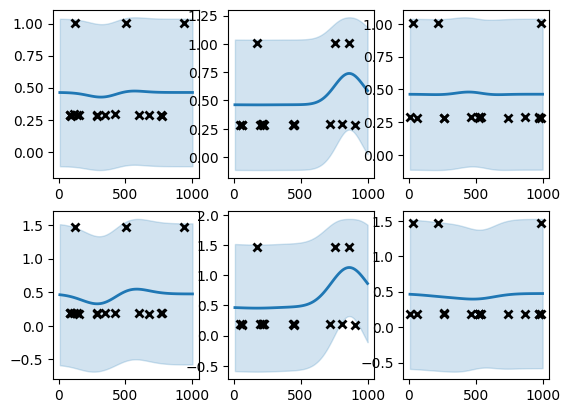

x_best =  [280.13206587  58.79717908 273.36541235]
acq_best =  [ 4.85117256e-17 -1.54932078e-17]
C = [280, 59, 0.1366827061773074]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 18860449792.0000 - mae: 236534.2031 - mse: 137985392640.0000 - val_loss: 15168110592.0000 - val_mae: 206585.1094 - val_mse: 110971650048.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 11301535744.0000 - mae: 181942.8281 - mse: 82683076608.0000 - val_loss: 8530922496.0000 - val_mae: 162476.9844 - val_mse: 62412877824.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 8749259776.0000 - mae: 167239.2969 - mse: 64010199040.0000 - val_loss: 8025216512.0000 - val_mae: 159071.2344 - val_mse: 58713047040.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 8534039040.0000 - mae: 164840.5469 - mse: 62435688448.0000 - val_loss: 7894846464.0000 - val_mae: 161893.1250 - val_mse: 57759195136.0000
Epoch 5/6
517/517 [=

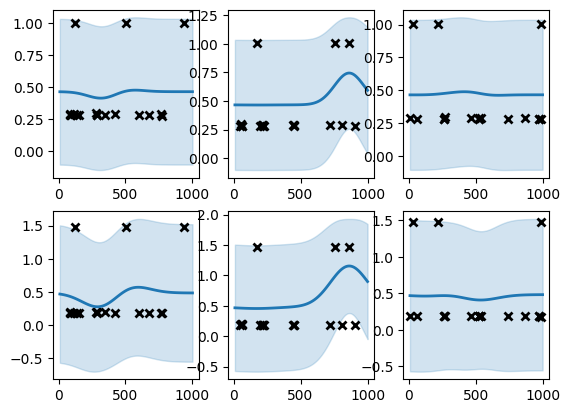

x_best =  [140.48478971 446.4542347  962.81164812]
acq_best =  [ 8.34056095e-16 -1.57037562e-17]
C = [140, 446, 0.4814058240608046]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 63427272704.0000 - mae: 230264.0938 - mse: 131753656320.0000 - val_loss: 48880017408.0000 - val_mae: 202031.1094 - val_mse: 101535563776.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 35959934976.0000 - mae: 173289.4531 - mse: 74697433088.0000 - val_loss: 27871477760.0000 - val_mae: 157254.1250 - val_mse: 57895698432.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 29007536128.0000 - mae: 162969.7969 - mse: 60255494144.0000 - val_loss: 27571095552.0000 - val_mae: 158498.3125 - val_mse: 57271713792.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 28130410496.0000 - mae: 160910.6250 - mse: 58433572864.0000 - val_loss: 26257782784.0000 - val_mae: 154009.8750 - val_mse: 54543626240.0000
Epoch 5/6
517/

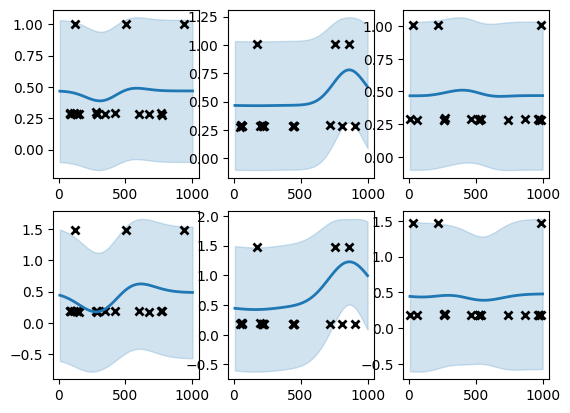

x_best =  [770.49135856 820.64269258 465.02874795]
acq_best =  [-4.74469561e-18 -1.22867648e-17]
C = [770, 821, 0.23251437397356775]
Epoch 1/6
517/517 [==============================] - 5s 9ms/step - loss: 23960649728.0000 - mae: 202940.1406 - mse: 103049248768.0000 - val_loss: 13470793728.0000 - val_mae: 164148.9844 - val_mse: 57934589952.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 13990074368.0000 - mae: 162811.3750 - mse: 60167921664.0000 - val_loss: 12942988288.0000 - val_mae: 156907.4375 - val_mse: 55664664576.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 13683515392.0000 - mae: 161698.4062 - mse: 58849476608.0000 - val_loss: 15412009984.0000 - val_mae: 188066.9219 - val_mse: 66283286528.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 13503800320.0000 - mae: 160301.6094 - mse: 58076610560.0000 - val_loss: 12814219264.0000 - val_mae: 151028.2188 - val_mse: 55110873088.0000
Epoch 5/6
517/

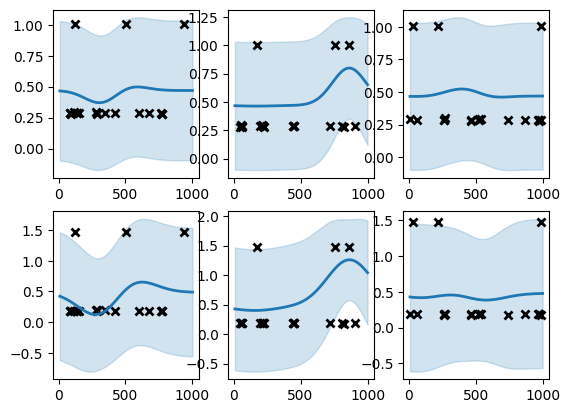

x_best =  [ 95.14905338 241.45150244 531.26022044]
acq_best =  [-1.16013032e-17  3.49351555e-12]
C = [95, 242, 0.2656301102217491]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 36049223680.0000 - mae: 236523.5781 - mse: 135711105024.0000 - val_loss: 29605492736.0000 - val_mae: 214742.5469 - val_mse: 111453069312.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 21710946304.0000 - mae: 181360.9531 - mse: 81733009408.0000 - val_loss: 16047335424.0000 - val_mae: 160116.1406 - val_mse: 60411748352.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 16683365376.0000 - mae: 164421.2656 - mse: 62806142976.0000 - val_loss: 15133592576.0000 - val_mae: 159356.3125 - val_mse: 56971825152.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 16168396800.0000 - mae: 163532.4688 - mse: 60867465216.0000 - val_loss: 14982203392.0000 - val_mae: 156758.5469 - val_mse: 56401899520.0000
Epoch 5/6
517/5

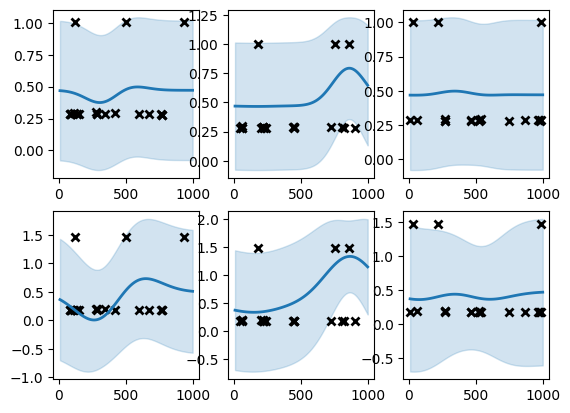

x_best =  [127.42497562 227.98841616 508.10243499]
acq_best =  [-1.01068979e-17  1.58380669e-07]
C = [127, 228, 0.2540512174961907]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 34359085056.0000 - mae: 234170.2812 - mse: 135243751424.0000 - val_loss: 28427968512.0000 - val_mae: 212349.0625 - val_mse: 111897739264.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 20951066624.0000 - mae: 182208.8594 - mse: 82467176448.0000 - val_loss: 16077660160.0000 - val_mae: 158886.7500 - val_mse: 63284502528.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 15698780160.0000 - mae: 163521.4375 - mse: 61793083392.0000 - val_loss: 14223281152.0000 - val_mae: 159241.5781 - val_mse: 55985258496.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 14887635968.0000 - mae: 160535.3594 - mse: 58600296448.0000 - val_loss: 13997606912.0000 - val_mae: 157717.7031 - val_mse: 55096958976.0000
Epoch 5/6
517/

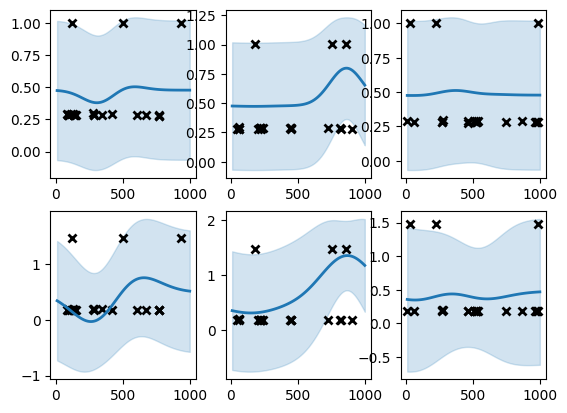

x_best =  [104.22080423 233.69242196 565.99762406]
acq_best =  [-9.55500573e-18  4.04623992e-18]
C = [104, 234, 0.28299881203127664]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 39157792768.0000 - mae: 237471.7188 - mse: 138366582784.0000 - val_loss: 31918604288.0000 - val_mae: 225136.5312 - val_mse: 112786292736.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 24358381568.0000 - mae: 184389.7031 - mse: 86071648256.0000 - val_loss: 17952516096.0000 - val_mae: 159377.4219 - val_mse: 63436148736.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 17986914304.0000 - mae: 165119.5312 - mse: 63557681152.0000 - val_loss: 16544507904.0000 - val_mae: 158934.6875 - val_mse: 58460835840.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 17303779328.0000 - mae: 163603.0625 - mse: 61143814144.0000 - val_loss: 15899939840.0000 - val_mae: 160412.5625 - val_mse: 56183193600.0000
Epoch 5/6
517

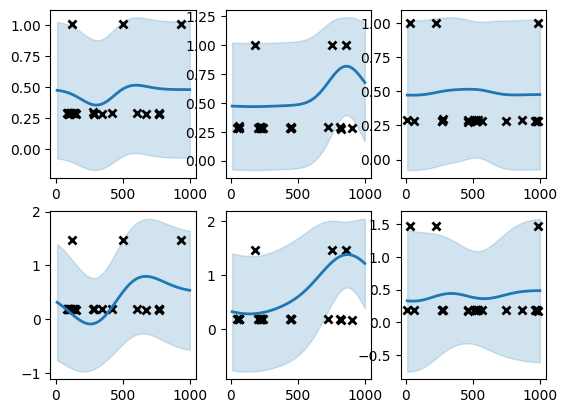

x_best =  [288.69558977  49.34424471 263.70697172]
acq_best =  [-1.06327547e-17  1.86296403e-11]
C = [289, 49, 0.13185348586026746]
Epoch 1/6
517/517 [==============================] - 1s 1ms/step - loss: 19091314688.0000 - mae: 243269.5781 - mse: 144790028288.0000 - val_loss: 15240098816.0000 - val_mae: 227718.0781 - val_mse: 115581837312.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 12067945472.0000 - mae: 188814.3906 - mse: 91523948544.0000 - val_loss: 8953373696.0000 - val_mae: 176515.7500 - val_mse: 67902631936.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 8323811840.0000 - mae: 163266.0625 - mse: 63128018944.0000 - val_loss: 7720280576.0000 - val_mae: 156674.7500 - val_mse: 58550751232.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 7863981056.0000 - mae: 160631.7031 - mse: 59640565760.0000 - val_loss: 7195260928.0000 - val_mae: 153467.3906 - val_mse: 54568947712.0000
Epoch 5/6
517/517 [

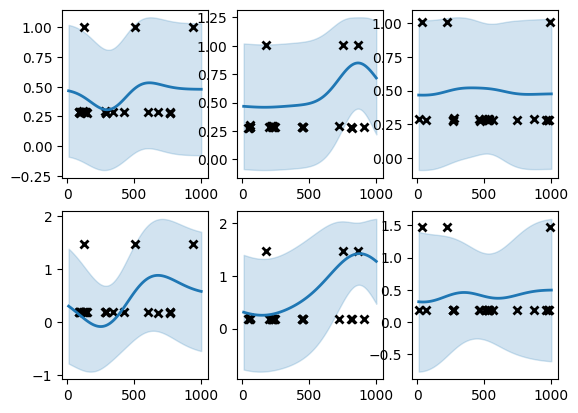

x_best =  [102.64484986 229.92891488 607.81986168]
acq_best =  [-9.77606739e-18  6.02109912e-08]
C = [103, 230, 0.3039099308413339]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 43316076544.0000 - mae: 243080.4062 - mse: 142528512000.0000 - val_loss: 34459426816.0000 - val_mae: 215534.9531 - val_mse: 113386323968.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 26780229632.0000 - mae: 187009.2812 - mse: 88118321152.0000 - val_loss: 19663486976.0000 - val_mae: 160904.9688 - val_mse: 64701165568.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 19110342656.0000 - mae: 164046.4844 - mse: 62881062912.0000 - val_loss: 17187497984.0000 - val_mae: 158973.8906 - val_mse: 56554061824.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 18077452288.0000 - mae: 161687.1562 - mse: 59482427392.0000 - val_loss: 17965398016.0000 - val_mae: 172176.6562 - val_mse: 59113652224.0000
Epoch 5/6
517/

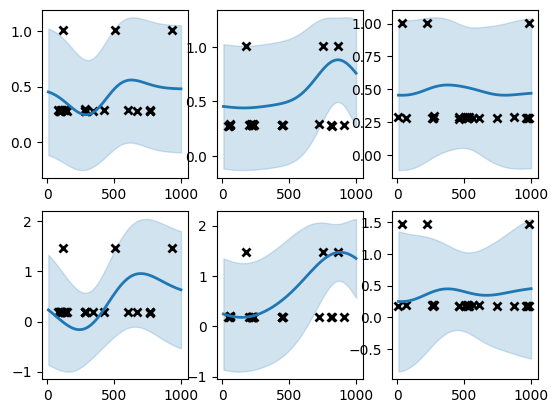

x_best =  [107.91189971 202.25401482 476.50102833]
acq_best =  [-9.03583453e-18  4.52645203e-06]
C = [108, 203, 0.23825051416564835]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 32172015616.0000 - mae: 233736.4375 - mse: 135033421824.0000 - val_loss: 26758279168.0000 - val_mae: 218163.9375 - val_mse: 112310607872.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 20363642880.0000 - mae: 183900.7188 - mse: 85470797824.0000 - val_loss: 14469409792.0000 - val_mae: 159311.0938 - val_mse: 60731232256.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 14633558016.0000 - mae: 163072.3594 - mse: 61420224512.0000 - val_loss: 13281115136.0000 - val_mae: 159587.4375 - val_mse: 55743684608.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 13986565120.0000 - mae: 160510.1250 - mse: 58704642048.0000 - val_loss: 13514539008.0000 - val_mae: 154535.4844 - val_mse: 56723439616.0000
Epoch 5/6
517

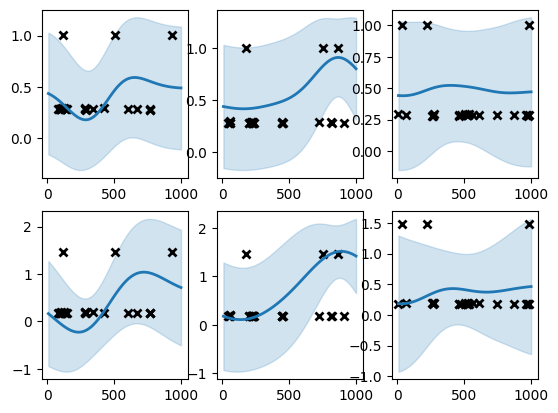

x_best =  [329.58665581 194.03825799  60.59670834]
acq_best =  [-1.0394905e-17  2.4542101e-05]
C = [330, 194, 0.030298354170978002]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 3838990592.0000 - mae: 226682.8125 - mse: 126698782720.0000 - val_loss: 2668149504.0000 - val_mae: 181073.6875 - val_mse: 88056520704.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 2043952768.0000 - mae: 167549.1406 - mse: 67455307776.0000 - val_loss: 1820753408.0000 - val_mae: 169621.6250 - val_mse: 60088537088.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 1811071744.0000 - mae: 162607.6250 - mse: 59769217024.0000 - val_loss: 1669488640.0000 - val_mae: 160131.4844 - val_mse: 55096332288.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 1768668800.0000 - mae: 161291.2969 - mse: 58369761280.0000 - val_loss: 1897246976.0000 - val_mae: 162642.5469 - val_mse: 62613438464.0000
Epoch 5/6
517/517 [====

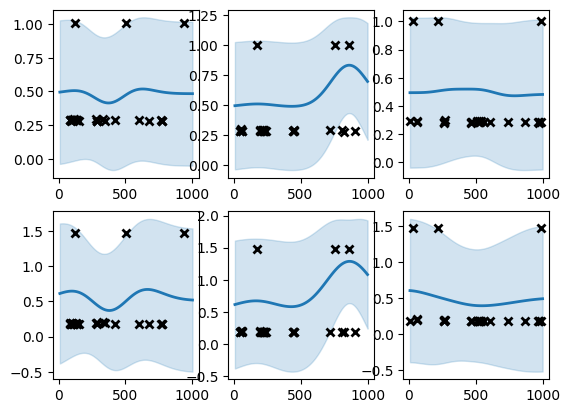

x_best =  [135.77516093 235.35739782 618.14889691]
acq_best =  [ 1.72392042e-09 -2.20756389e-17]
C = [136, 235, 0.30907444845296866]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 130751602688.0000 - mae: 538371.4375 - mse: 423040712704.0000 - val_loss: 132915863552.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 130751643648.0000 - mae: 538371.4375 - mse: 423040647168.0000 - val_loss: 132915863552.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 130751586304.0000 - mae: 538371.3750 - mse: 423040647168.0000 - val_loss: 132915863552.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 130751684608.0000 - mae: 538371.6875 - mse: 423040745472.0000 - val_loss: 132915863552.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000

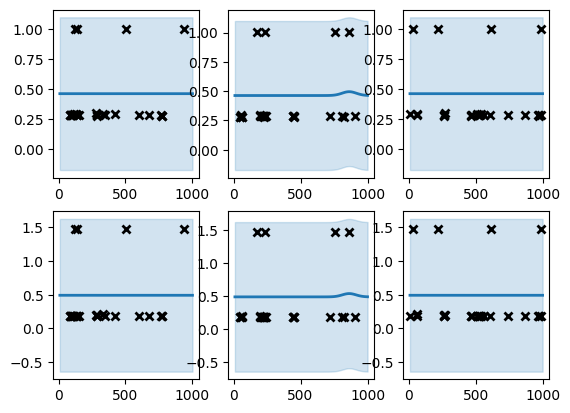

x_best =  [768.28190931 819.62452277 468.01689359]
acq_best =  [-9.85473831e-18  3.97955345e-16]
C = [768, 820, 0.234008446793629]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 56602177536.0000 - mae: 346571.6250 - mse: 241879613440.0000 - val_loss: 15362591744.0000 - val_mae: 163673.0156 - val_mse: 65649049600.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 14505024512.0000 - mae: 164702.7344 - mse: 61984292864.0000 - val_loss: 14453574656.0000 - val_mae: 177354.7188 - val_mse: 61764435968.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 13839036416.0000 - mae: 162059.2656 - mse: 59138392064.0000 - val_loss: 12783804416.0000 - val_mae: 154885.1250 - val_mse: 54628995072.0000
Epoch 4/6
517/517 [==============================] - 5s 11ms/step - loss: 13574096896.0000 - mae: 160559.8594 - mse: 58006167552.0000 - val_loss: 12998197248.0000 - val_mae: 160597.2500 - val_mse: 55545151488.0000
Epoch 5/6
517/5

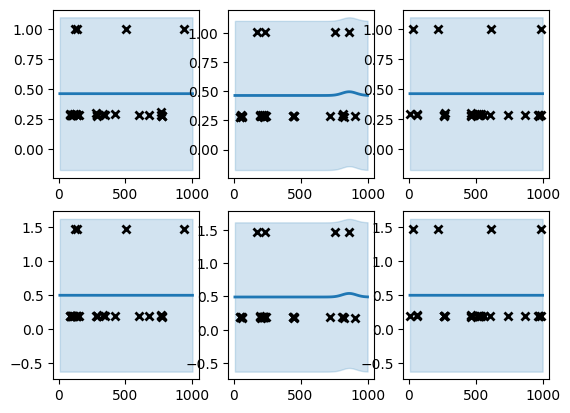

x_best =  [ 88.32999189 226.71885493 602.56623178]
acq_best =  [-2.20154993e-17  3.21775806e-18]
C = [88, 227, 0.3012831158903517]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 41719238656.0000 - mae: 237940.4375 - mse: 138471129088.0000 - val_loss: 34770092032.0000 - val_mae: 215814.3594 - val_mse: 115405963264.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 27920285696.0000 - mae: 190934.9219 - mse: 92670607360.0000 - val_loss: 19759935488.0000 - val_mae: 164311.3438 - val_mse: 65585401856.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 18872348672.0000 - mae: 162257.0469 - mse: 62639345664.0000 - val_loss: 17189363712.0000 - val_mae: 163454.3594 - val_mse: 57053339648.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 18399715328.0000 - mae: 163033.4531 - mse: 61070614528.0000 - val_loss: 16818557952.0000 - val_mae: 155583.2344 - val_mse: 55822610432.0000
Epoch 5/6
517/5

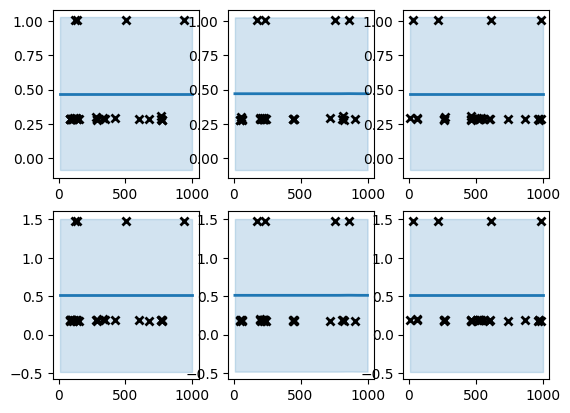

x_best =  [347.75655908 204.43692927  64.19440484]
acq_best =  [-9.97114217e-18  1.03357091e-17]
C = [347, 205, 0.03209720242028941]
Epoch 1/6
517/517 [==============================] - 5s 6ms/step - loss: 13578973184.0000 - mae: 538371.4375 - mse: 423040745472.0000 - val_loss: 13803722752.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 13578966016.0000 - mae: 538371.2500 - mse: 423040876544.0000 - val_loss: 13803722752.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 13578960896.0000 - mae: 538371.5625 - mse: 423040483328.0000 - val_loss: 13803722752.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 13578953728.0000 - mae: 538371.6875 - mse: 423040942080.0000 - val_loss: 13803722752.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5

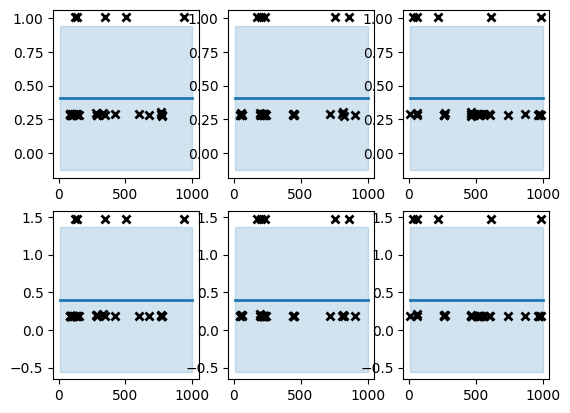

x_best =  [768.27266747 819.50486027 467.96285476]
acq_best =  [-4.09858964e-18  3.85318011e-16]
C = [768, 819, 0.23398142738093475]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 23412926464.0000 - mae: 202232.2031 - mse: 100062298112.0000 - val_loss: 13583088640.0000 - val_mae: 159510.5312 - val_mse: 58051317760.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 14191657984.0000 - mae: 163540.5156 - mse: 60652257280.0000 - val_loss: 12881954816.0000 - val_mae: 155205.5156 - val_mse: 55054819328.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 13635204096.0000 - mae: 161447.2812 - mse: 58274021376.0000 - val_loss: 13139276800.0000 - val_mae: 159088.3125 - val_mse: 56154525696.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 13433566208.0000 - mae: 159266.8125 - mse: 57412325376.0000 - val_loss: 13447302144.0000 - val_mae: 155603.2656 - val_mse: 57470980096.0000
Epoch 5/6
517/

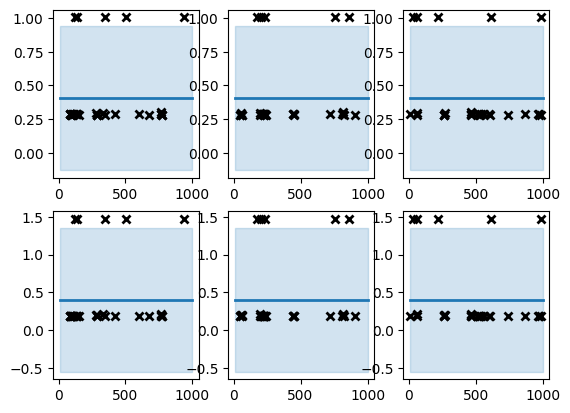

x_best =  [107.9848406  202.35050074 476.42464214]
acq_best =  [3.39102815e-16 1.72436010e-18]
C = [108, 202, 0.23821232107241638]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 33874466816.0000 - mae: 240301.4375 - mse: 142201847808.0000 - val_loss: 27388549120.0000 - val_mae: 216317.8906 - val_mse: 114974482432.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 21291923456.0000 - mae: 189262.1719 - mse: 89381355520.0000 - val_loss: 15128677376.0000 - val_mae: 160824.4844 - val_mse: 63508545536.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 14930371584.0000 - mae: 163891.0625 - mse: 62676008960.0000 - val_loss: 13499794432.0000 - val_mae: 158572.9219 - val_mse: 56670613504.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 14373488640.0000 - mae: 162836.0000 - mse: 60338270208.0000 - val_loss: 13180542976.0000 - val_mae: 155936.7500 - val_mse: 55330402304.0000
Epoch 5/6
517/5

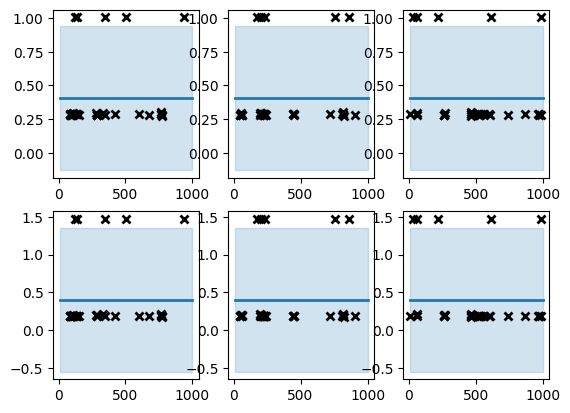

x_best =  [286.52950764  61.08861567 267.24099288]
acq_best =  [2.22582114e-07 1.54382192e-14]
C = [286, 61, 0.13362049644053725]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 18225559552.0000 - mae: 235440.6250 - mse: 136396079104.0000 - val_loss: 14511469568.0000 - val_mae: 215031.9688 - val_mse: 108600549376.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 11025648640.0000 - mae: 181567.7344 - mse: 82513289216.0000 - val_loss: 8356669952.0000 - val_mae: 158975.5469 - val_mse: 62539108352.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 8278940160.0000 - mae: 162952.2656 - mse: 61957337088.0000 - val_loss: 7715175936.0000 - val_mae: 157907.7656 - val_mse: 57738289152.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 7935477760.0000 - mae: 160674.6875 - mse: 59386990592.0000 - val_loss: 7373853696.0000 - val_mae: 156955.0625 - val_mse: 55183863808.0000
Epoch 5/6
517/517 [==

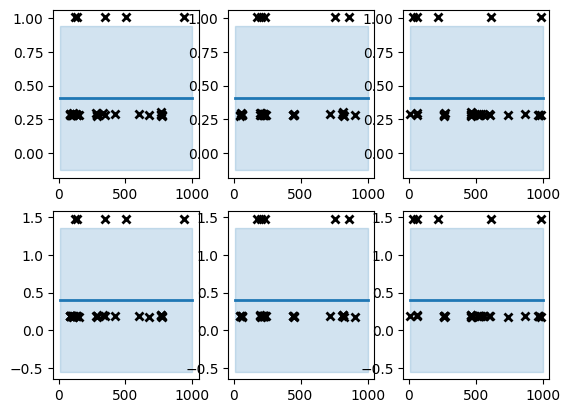

x_best =  [ 84.54581913 221.13935461 524.41176517]
acq_best =  [ 8.36459623e-14 -1.22344394e-17]
C = [84, 222, 0.2622058825864436]
Epoch 1/6
517/517 [==============================] - 4s 4ms/step - loss: 38341865472.0000 - mae: 246214.8125 - mse: 146227134464.0000 - val_loss: 30477627392.0000 - val_mae: 217894.1250 - val_mse: 116234641408.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 24422377472.0000 - mae: 192411.2969 - mse: 93141172224.0000 - val_loss: 17716228096.0000 - val_mae: 174834.9688 - val_mse: 67565420544.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 16963147776.0000 - mae: 167103.6094 - mse: 64693374976.0000 - val_loss: 16606873600.0000 - val_mae: 178141.1094 - val_mse: 63334563840.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 16173280256.0000 - mae: 164898.3125 - mse: 61681004544.0000 - val_loss: 14886328320.0000 - val_mae: 158434.4219 - val_mse: 56772849664.0000
Epoch 5/6
517/5

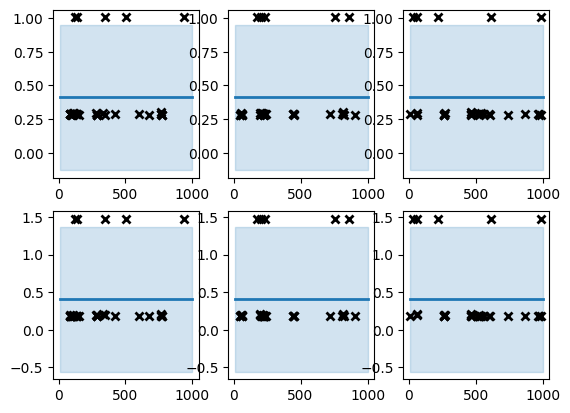

x_best =  [768.91637754  45.62811198 976.61184581]
acq_best =  [ 6.17906781e-17 -1.20399230e-17]
C = [769, 46, 0.48830592290331615]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 63532781568.0000 - mae: 229471.0469 - mse: 130107924480.0000 - val_loss: 45153509376.0000 - val_mae: 192158.5469 - val_mse: 92469256192.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 34475077632.0000 - mae: 169027.3438 - mse: 70600998912.0000 - val_loss: 28164857856.0000 - val_mae: 160467.7812 - val_mse: 57678397440.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 29424089088.0000 - mae: 162019.2188 - mse: 60257132544.0000 - val_loss: 26862948352.0000 - val_mae: 155540.4531 - val_mse: 55012225024.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 28522848256.0000 - mae: 160421.0156 - mse: 58411495424.0000 - val_loss: 26770632704.0000 - val_mae: 155062.1094 - val_mse: 54823157760.0000
Epoch 5/6
517/5

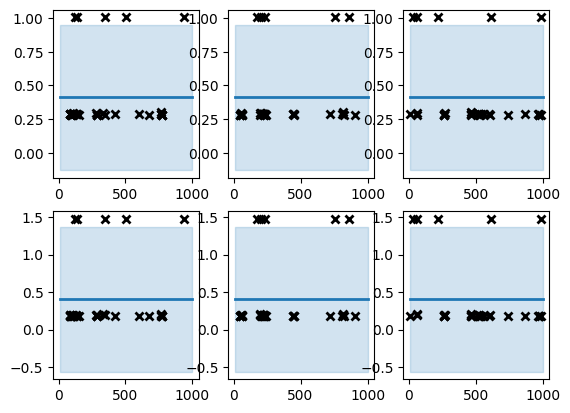

x_best =  [150.29645242 451.96758682 744.78655525]
acq_best =  [ 1.29545821e-15 -1.21992621e-17]
C = [151, 452, 0.3723932776266407]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 157538009088.0000 - mae: 538371.8125 - mse: 423040876544.0000 - val_loss: 160145637376.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 157538041856.0000 - mae: 538371.6875 - mse: 423040712704.0000 - val_loss: 160145637376.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 157538189312.0000 - mae: 538372.0000 - mse: 423040942080.0000 - val_loss: 160145637376.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 157538074624.0000 - mae: 538371.8125 - mse: 423040516096.0000 - val_loss: 160145637376.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000


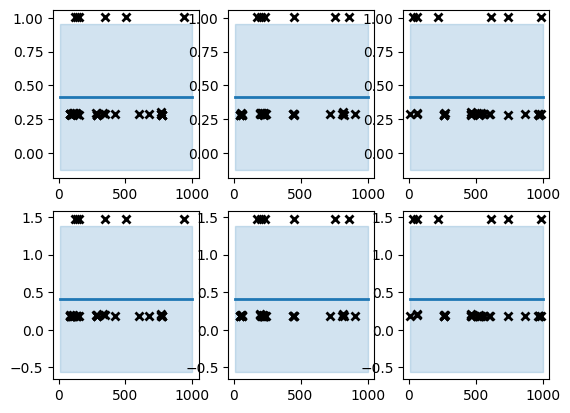

x_best =  [101.58412519 636.36531145 418.06574623]
acq_best =  [0.10795205 0.19345595]
C = [102, 636, 0.20903287311675176]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 28171646976.0000 - mae: 233031.6406 - mse: 134770278400.0000 - val_loss: 22577786880.0000 - val_mae: 218480.1875 - val_mse: 108009668608.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 16259225600.0000 - mae: 175935.1250 - mse: 77782319104.0000 - val_loss: 12652228608.0000 - val_mae: 162124.2969 - val_mse: 60526682112.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 12553469952.0000 - mae: 161360.9844 - mse: 60054278144.0000 - val_loss: 11644377088.0000 - val_mae: 160325.9844 - val_mse: 55705194496.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 12421800960.0000 - mae: 162717.2969 - mse: 59424350208.0000 - val_loss: 12138597376.0000 - val_mae: 163504.5625 - val_mse: 58069491712.0000
Epoch 5/6
517/517 [====

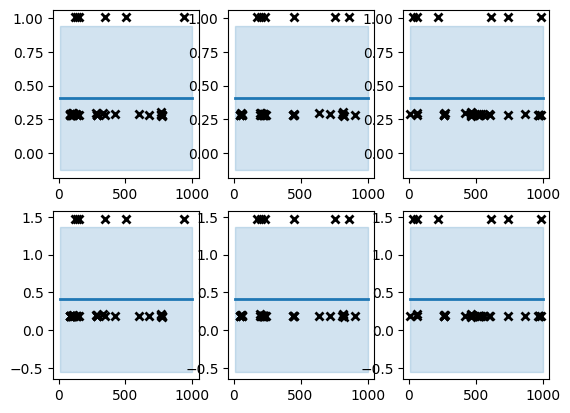

x_best =  [631.47059293 337.8528296  672.60370225]
acq_best =  [0.10663996 0.19118202]
C = [631, 338, 0.3363018511246539]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 36315123712.0000 - mae: 208958.0938 - mse: 107983060992.0000 - val_loss: 20237191168.0000 - val_mae: 167007.5000 - val_mse: 60175159296.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 20778229760.0000 - mae: 164974.8125 - mse: 61783973888.0000 - val_loss: 20048564224.0000 - val_mae: 157715.6250 - val_mse: 59614318592.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 19846123520.0000 - mae: 161216.4062 - mse: 59012341760.0000 - val_loss: 18771765248.0000 - val_mae: 158625.1406 - val_mse: 55817728000.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 19365165056.0000 - mae: 159775.9531 - mse: 57582264320.0000 - val_loss: 18579017728.0000 - val_mae: 151780.0156 - val_mse: 55244591104.0000
Epoch 5/6
517/517 [======

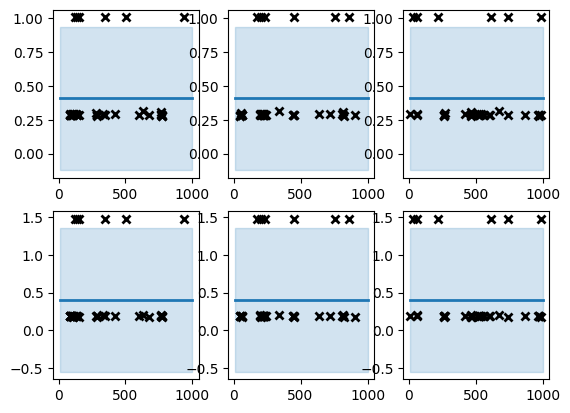

x_best =  [337.35093176 221.10420325 163.30911224]
acq_best =  [0.10527219 0.18891565]
C = [338, 221, 0.08165455611962989]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 10239157248.0000 - mae: 224294.8906 - mse: 125393289216.0000 - val_loss: 6831705600.0000 - val_mae: 195183.9219 - val_mse: 83663552512.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 5405497856.0000 - mae: 167441.7344 - mse: 66197508096.0000 - val_loss: 4769613824.0000 - val_mae: 159030.0938 - val_mse: 58410160128.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 4973581312.0000 - mae: 163683.2969 - mse: 60908023808.0000 - val_loss: 4526076928.0000 - val_mae: 154945.2500 - val_mse: 55427678208.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 4772135424.0000 - mae: 160537.5469 - mse: 58441031680.0000 - val_loss: 4425052672.0000 - val_mae: 152909.8438 - val_mse: 54190469120.0000
Epoch 5/6
517/517 [============

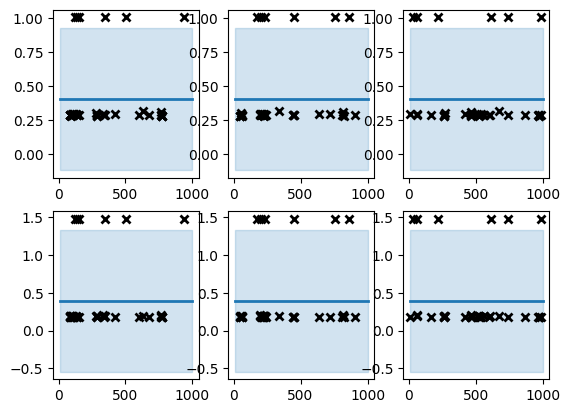

x_best =  [515.25905402  58.55544378 660.76397548]
acq_best =  [0.10409517 0.18680497]
C = [515, 59, 0.33038198773953065]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 43269095424.0000 - mae: 229813.1094 - mse: 130966274048.0000 - val_loss: 32573362176.0000 - val_mae: 187830.2188 - val_mse: 98592473088.0000
Epoch 2/6
517/517 [==============================] - 1s 1ms/step - loss: 23366526976.0000 - mae: 170332.6562 - mse: 70725206016.0000 - val_loss: 20595193856.0000 - val_mae: 163767.9688 - val_mse: 62337015808.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 19974227968.0000 - mae: 162802.9844 - mse: 60457492480.0000 - val_loss: 18677704704.0000 - val_mae: 155055.8438 - val_mse: 56533196800.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 19642968064.0000 - mae: 161998.7656 - mse: 59454844928.0000 - val_loss: 18331813888.0000 - val_mae: 152820.9062 - val_mse: 55486259200.0000
Epoch 5/6
517/517 [======

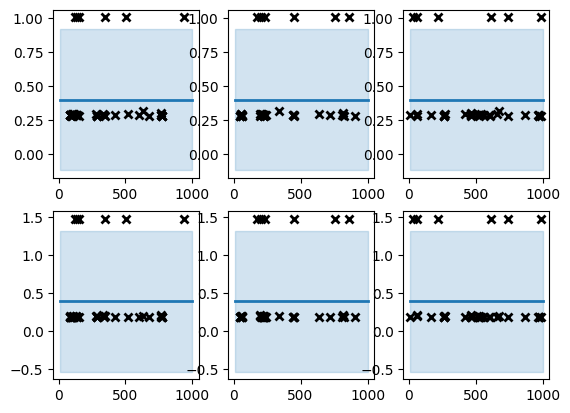

x_best =  [222.54341217 673.55514367 545.88672023]
acq_best =  [0.10290475 0.18474416]
C = [222, 673, 0.27294336011657006]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 115466739712.0000 - mae: 538371.5000 - mse: 423040909312.0000 - val_loss: 117377941504.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 115466641408.0000 - mae: 538371.3750 - mse: 423040778240.0000 - val_loss: 117377941504.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 115466723328.0000 - mae: 538371.3750 - mse: 423040647168.0000 - val_loss: 117377941504.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 115466657792.0000 - mae: 538371.5625 - mse: 423040647168.0000 - val_loss: 117377941504.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6

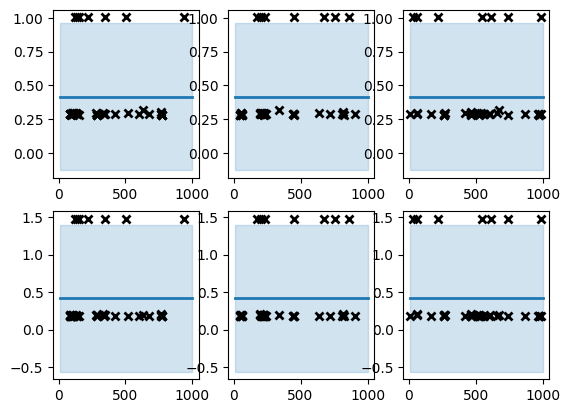

x_best =  [921.32190273 669.3350881  678.29923832]
acq_best =  [0.1086717  0.19511004]
C = [922, 669, 0.33914961916166086]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 35529560064.0000 - mae: 207126.0781 - mse: 104760041472.0000 - val_loss: 19702470656.0000 - val_mae: 157262.3594 - val_mse: 58093273088.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 20830552064.0000 - mae: 164660.9688 - mse: 61419421696.0000 - val_loss: 18987759616.0000 - val_mae: 153082.4688 - val_mse: 55985938432.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 19575920640.0000 - mae: 159781.9844 - mse: 57720143872.0000 - val_loss: 18630780928.0000 - val_mae: 157378.2812 - val_mse: 54933360640.0000
Epoch 4/6
517/517 [==============================] - 5s 10ms/step - loss: 19818006528.0000 - mae: 159919.6719 - mse: 58433941504.0000 - val_loss: 18972786688.0000 - val_mae: 163374.4219 - val_mse: 55941722112.0000
Epoch 5/6
517/517 [==

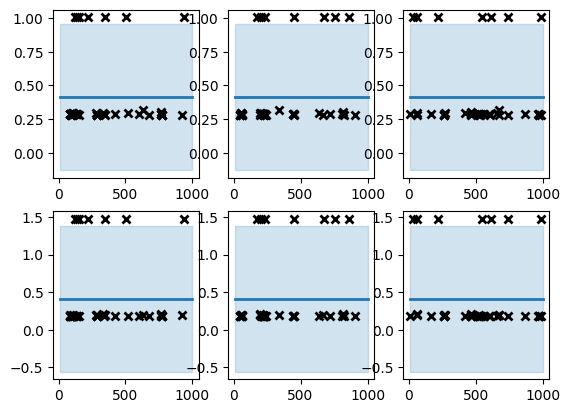

x_best =  [946.96949075 929.49269968 712.45016816]
acq_best =  [0.10758958 0.19307221]
C = [947, 930, 0.3562250840823127]
Epoch 1/6
517/517 [==============================] - 10s 17ms/step - loss: 150698213376.0000 - mae: 538371.5625 - mse: 423040516096.0000 - val_loss: 153192660992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 9s 18ms/step - loss: 150698246144.0000 - mae: 538371.6875 - mse: 423040811008.0000 - val_loss: 153192660992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 7s 13ms/step - loss: 150698262528.0000 - mae: 538371.5000 - mse: 423040778240.0000 - val_loss: 153192660992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 150698246144.0000 - mae: 538371.4375 - mse: 423040745472.0000 - val_loss: 153192660992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch

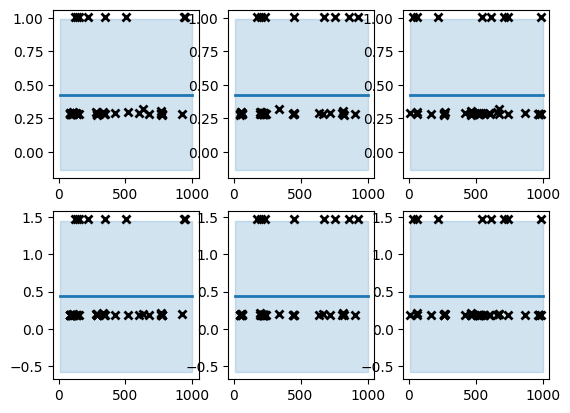

x_best =  [ 88.69047779 843.28713949 559.06429003]
acq_best =  [0.11252102 0.20193005]
C = [89, 843, 0.2795321450159382]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 118253944832.0000 - mae: 538371.3750 - mse: 423040450560.0000 - val_loss: 120211382272.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 118254034944.0000 - mae: 538371.1875 - mse: 423040876544.0000 - val_loss: 120211382272.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 118254018560.0000 - mae: 538371.1875 - mse: 423040876544.0000 - val_loss: 120211382272.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 118253969408.0000 - mae: 538371.3750 - mse: 423040516096.0000 - val_loss: 120211382272.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
5

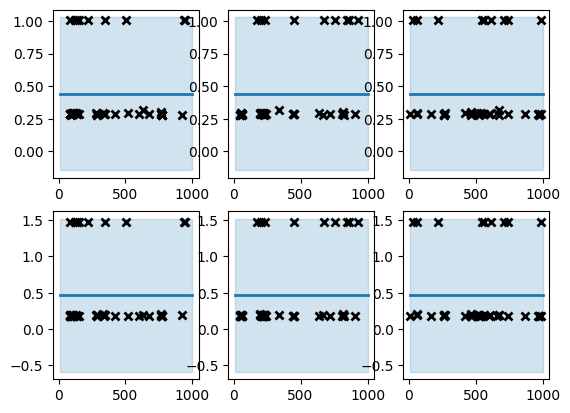

x_best =  [686.65496292 554.66355139 768.68633178]
acq_best =  [0.11675972 0.20954537]
C = [686, 555, 0.38434316589067885]
Epoch 1/6
517/517 [==============================] - 6s 9ms/step - loss: 40796205056.0000 - mae: 205264.4688 - mse: 106144686080.0000 - val_loss: 23714799616.0000 - val_mae: 158027.0625 - val_mse: 61701742592.0000
Epoch 2/6
517/517 [==============================] - 5s 9ms/step - loss: 23184906240.0000 - mae: 162764.9531 - mse: 60323028992.0000 - val_loss: 21810372608.0000 - val_mae: 166363.2188 - val_mse: 56746700800.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 22679476224.0000 - mae: 162185.3750 - mse: 59007959040.0000 - val_loss: 23487352832.0000 - val_mae: 160726.0625 - val_mse: 61109964800.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 22280564736.0000 - mae: 160145.8281 - mse: 57970020352.0000 - val_loss: 20582379520.0000 - val_mae: 153875.0781 - val_mse: 53551693824.0000
Epoch 5/6
517/517 [=====

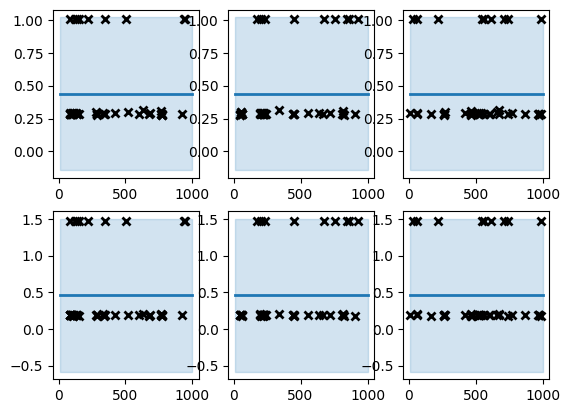

x_best =  [362.61052785 350.09926485 385.48476332]
acq_best =  [0.11568359 0.2076336 ]
C = [363, 350, 0.19274238165835328]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 23373547520.0000 - mae: 220971.8906 - mse: 121267200000.0000 - val_loss: 13961186304.0000 - val_mae: 175094.0469 - val_mse: 72433573888.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 12502389760.0000 - mae: 166704.3125 - mse: 64864948224.0000 - val_loss: 11142166528.0000 - val_mae: 157750.1875 - val_mse: 57807790080.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 11443992576.0000 - mae: 162484.4844 - mse: 59373731840.0000 - val_loss: 11005245440.0000 - val_mae: 160248.1562 - val_mse: 57097383936.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 11136211968.0000 - mae: 160240.0781 - mse: 57776852992.0000 - val_loss: 10508941312.0000 - val_mae: 156018.6562 - val_mse: 54522437632.0000
Epoch 5/6
517/517 [=====

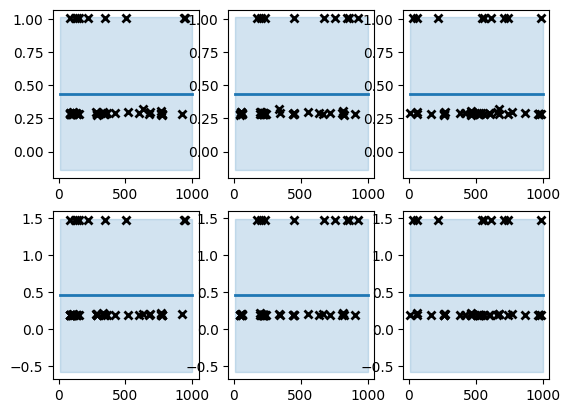

x_best =  [961.39488718 707.58089824 936.88864023]
acq_best =  [0.11467291 0.20583082]
C = [961, 708, 0.46844432011257403]
Epoch 1/6
517/517 [==============================] - 7s 12ms/step - loss: 50326511616.0000 - mae: 205425.6406 - mse: 107432951808.0000 - val_loss: 30213236736.0000 - val_mae: 162900.8750 - val_mse: 64496619520.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 28920899584.0000 - mae: 164497.7969 - mse: 61737865216.0000 - val_loss: 26587908096.0000 - val_mae: 155527.4688 - val_mse: 56757547008.0000
Epoch 3/6
517/517 [==============================] - 3s 7ms/step - loss: 27970529280.0000 - mae: 162829.5156 - mse: 59709075456.0000 - val_loss: 25955174400.0000 - val_mae: 152384.2812 - val_mse: 55406841856.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 26905300992.0000 - mae: 159417.5625 - mse: 57435111424.0000 - val_loss: 27278043136.0000 - val_mae: 170076.5312 - val_mse: 58230759424.0000
Epoch 5/6
517/517 [====

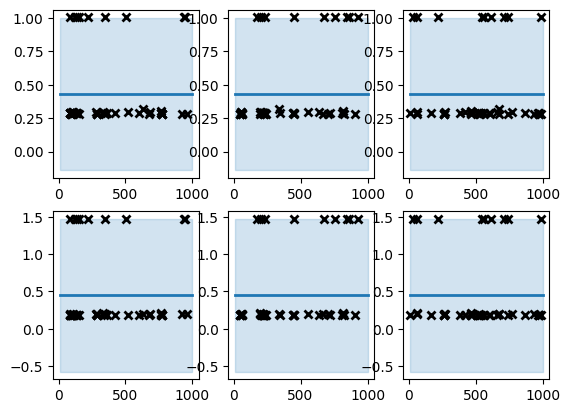

x_best =  [133.53031191  36.75358071  29.45210479]
acq_best =  [0.11369479 0.20400564]
C = [133, 37, 0.01472605239530914]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 2360723712.0000 - mae: 259014.6875 - mse: 160291684352.0000 - val_loss: 1743899392.0000 - val_mae: 220628.6094 - val_mse: 118407741440.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 1476525952.0000 - mae: 197805.4219 - mse: 100252852224.0000 - val_loss: 1112869120.0000 - val_mae: 168012.1094 - val_mse: 75560042496.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 1001286464.0000 - mae: 166816.2031 - mse: 67982958592.0000 - val_loss: 945106304.0000 - val_mae: 164017.4531 - val_mse: 64168079360.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 929835648.0000 - mae: 165242.0312 - mse: 63131017216.0000 - val_loss: 858208128.0000 - val_mae: 162190.3594 - val_mse: 58267230208.0000
Epoch 5/6
517/517 [===============

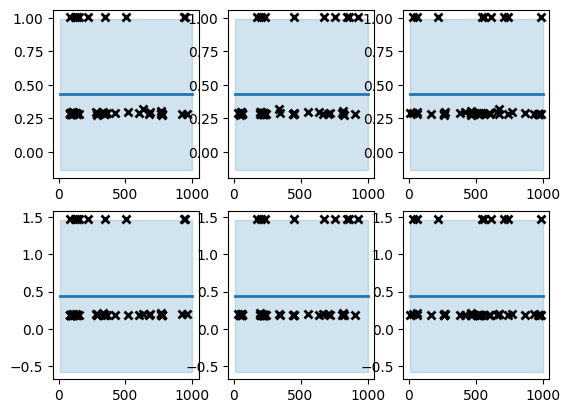

x_best =  [562.05418145 202.48192728 697.08492657]
acq_best =  [0.11270719 0.20223154]
C = [562, 202, 0.34854246328639404]
Epoch 1/6
517/517 [==============================] - 5s 6ms/step - loss: 41908854784.0000 - mae: 218399.1406 - mse: 120239677440.0000 - val_loss: 27283464192.0000 - val_mae: 168447.5469 - val_mse: 78278254592.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 22233020416.0000 - mae: 165318.8438 - mse: 63788048384.0000 - val_loss: 19741970432.0000 - val_mae: 162417.2969 - val_mse: 56641044480.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 20517439488.0000 - mae: 161783.5781 - mse: 58865942528.0000 - val_loss: 18912124928.0000 - val_mae: 153202.5938 - val_mse: 54260150272.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 20140967936.0000 - mae: 160187.2812 - mse: 57785831424.0000 - val_loss: 18933047296.0000 - val_mae: 157458.8438 - val_mse: 54320181248.0000
Epoch 5/6
517/517 [=====

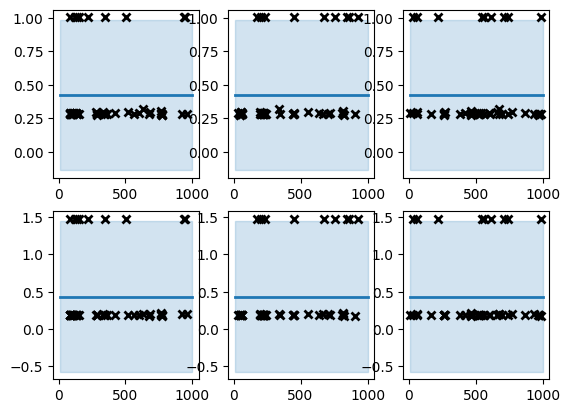

x_best =  [227.96302867 490.53725858 927.90705912]
acq_best =  [0.11178739 0.20054213]
C = [228, 491, 0.46395352955998276]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 56537538560.0000 - mae: 220749.2656 - mse: 121859907584.0000 - val_loss: 35949297664.0000 - val_mae: 188710.8281 - val_mse: 77484285952.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 30817372160.0000 - mae: 168232.7188 - mse: 66423050240.0000 - val_loss: 32167368704.0000 - val_mae: 173224.8750 - val_mse: 69332770816.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 27843545088.0000 - mae: 162549.4531 - mse: 60013273088.0000 - val_loss: 26161250304.0000 - val_mae: 153595.8281 - val_mse: 56387321856.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 27122739200.0000 - mae: 160522.7031 - mse: 58459721728.0000 - val_loss: 24896774144.0000 - val_mae: 152506.4375 - val_mse: 53661884416.0000
Epoch 5/6
517/517 [=====

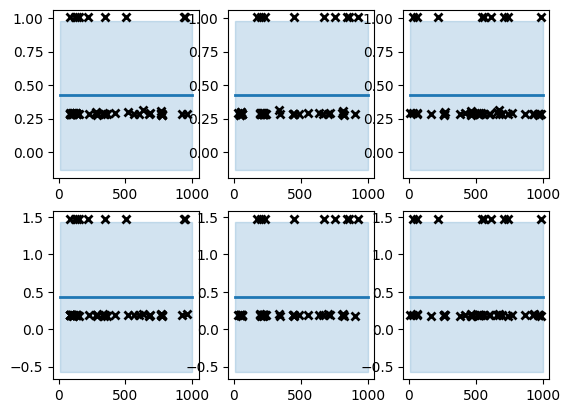

x_best =  [545.9390387  296.32507655  39.99642181]
acq_best =  [0.11086839 0.19884834]
C = [546, 296, 0.01999821090500818]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 2321588480.0000 - mae: 216496.2812 - mse: 116079017984.0000 - val_loss: 1368846208.0000 - val_mae: 164965.5938 - val_mse: 68440190976.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 1247776000.0000 - mae: 164411.5000 - mse: 62386176000.0000 - val_loss: 1147929600.0000 - val_mae: 159584.5312 - val_mse: 57393659904.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 1173829760.0000 - mae: 161220.2812 - mse: 58688655360.0000 - val_loss: 1098520448.0000 - val_mae: 153337.8125 - val_mse: 54923264000.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 1152935680.0000 - mae: 160194.7188 - mse: 57643941888.0000 - val_loss: 1096155008.0000 - val_mae: 160072.4375 - val_mse: 54804656128.0000
Epoch 5/6
517/517 [=============

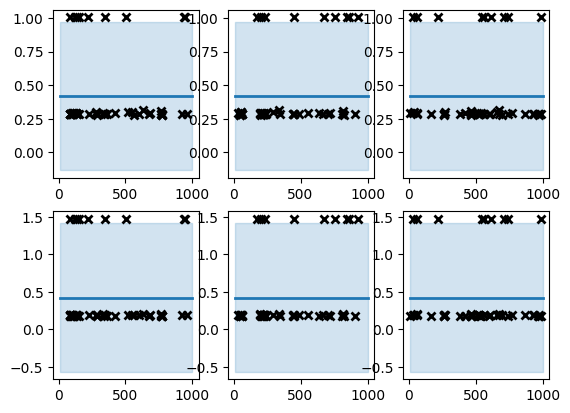

x_best =  [234.5252798  652.87812324  54.96425574]
acq_best =  [0.10991956 0.19722346]
C = [235, 653, 0.027482127869297997]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 11626589184.0000 - mae: 538371.4375 - mse: 423040614400.0000 - val_loss: 11819039744.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 11626599424.0000 - mae: 538371.6250 - mse: 423040811008.0000 - val_loss: 11819039744.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 11626599424.0000 - mae: 538371.4375 - mse: 423040614400.0000 - val_loss: 11819039744.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 11626592256.0000 - mae: 538371.6875 - mse: 423040843776.0000 - val_loss: 11819039744.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/51

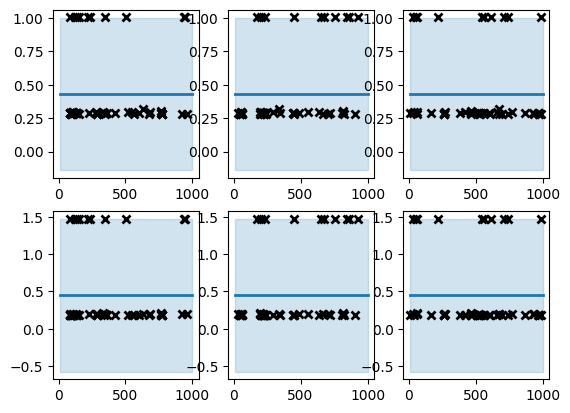

x_best =  [505.48900719 239.83048114  91.56071277]
acq_best =  [0.113743   0.20408941]
C = [506, 240, 0.04578035638252615]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 5397574656.0000 - mae: 216900.2500 - mse: 117896871936.0000 - val_loss: 3049662464.0000 - val_mae: 164751.7031 - val_mse: 66611474432.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 2890051584.0000 - mae: 164291.5625 - mse: 63125045248.0000 - val_loss: 2810098688.0000 - val_mae: 175925.2031 - val_mse: 61378330624.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 2662066432.0000 - mae: 160190.9062 - mse: 58145157120.0000 - val_loss: 2448702976.0000 - val_mae: 154380.4688 - val_mse: 53484699648.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 2630781440.0000 - mae: 160016.9375 - mse: 57461805056.0000 - val_loss: 2488729856.0000 - val_mae: 152057.8125 - val_mse: 54359076864.0000
Epoch 5/6
517/517 [=============

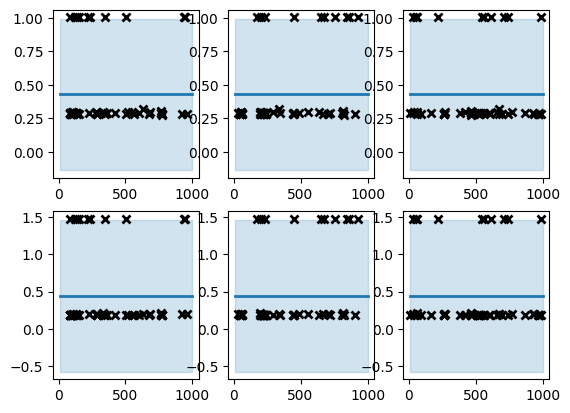

x_best =  [902.63651665  33.28329065 853.91245294]
acq_best =  [0.11291058 0.2025356 ]
C = [903, 33, 0.42695622647203757]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 180620328960.0000 - mae: 538371.3750 - mse: 423040942080.0000 - val_loss: 183610064896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 180620509184.0000 - mae: 538371.4375 - mse: 423040614400.0000 - val_loss: 183610064896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 180620328960.0000 - mae: 538371.4375 - mse: 423040843776.0000 - val_loss: 183610064896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 180620296192.0000 - mae: 538371.6250 - mse: 423040679936.0000 - val_loss: 183610064896.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6


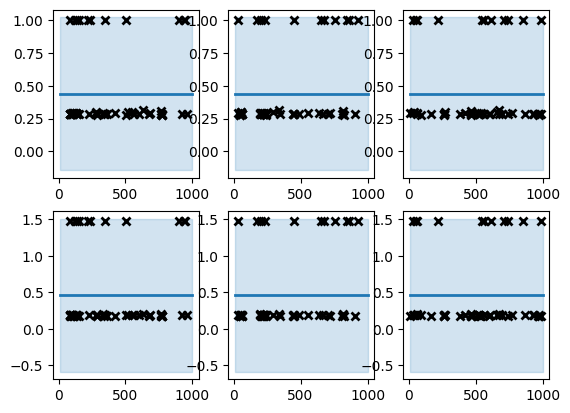

x_best =  [261.20135676 229.63889127 950.9376737 ]
acq_best =  [0.11630881 0.20863731]
C = [261, 230, 0.4754688368509834]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 59680186368.0000 - mae: 226183.8750 - mse: 125518118912.0000 - val_loss: 40854372352.0000 - val_mae: 189792.0625 - val_mse: 85923995648.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 31891582976.0000 - mae: 168115.9062 - mse: 67073601536.0000 - val_loss: 29504542720.0000 - val_mae: 161418.1250 - val_mse: 62053236736.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 28432281600.0000 - mae: 161866.9062 - mse: 59798089728.0000 - val_loss: 26558781440.0000 - val_mae: 153773.1250 - val_mse: 55857774592.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 27620909056.0000 - mae: 160038.7344 - mse: 58091585536.0000 - val_loss: 25919602688.0000 - val_mae: 153544.2188 - val_mse: 54513446912.0000
Epoch 5/6
517/517 [======

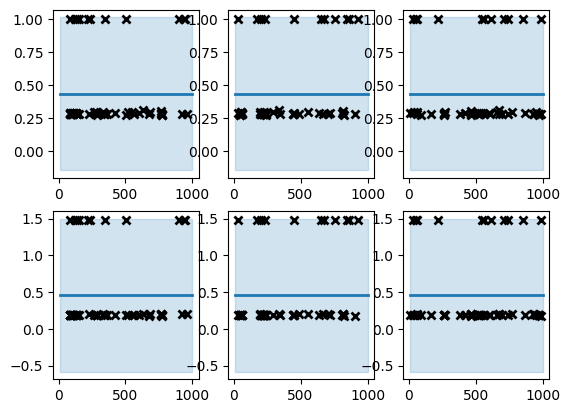

x_best =  [ 54.05765045  14.96067828 791.01044976]
acq_best =  [0.11544107 0.2071286 ]
C = [54, 15, 0.3955052248778803]
Epoch 1/6
517/517 [==============================] - 3s 3ms/step - loss: 167315439616.0000 - mae: 538371.0000 - mse: 423040778240.0000 - val_loss: 170084745216.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 167315292160.0000 - mae: 538371.4375 - mse: 423040581632.0000 - val_loss: 170084745216.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 167315275776.0000 - mae: 538371.3750 - mse: 423040876544.0000 - val_loss: 170084745216.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 167315292160.0000 - mae: 538371.2500 - mse: 423040516096.0000 - val_loss: 170084745216.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
51

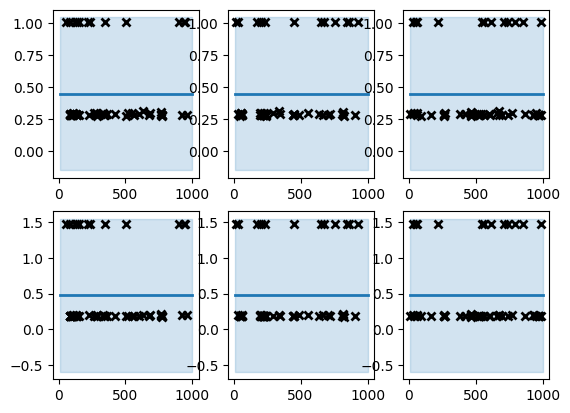

x_best =  [244.66938901 101.61906019 392.17543581]
acq_best =  [0.1184806  0.21258638]
C = [245, 101, 0.19608771790288904]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 82953609216.0000 - mae: 538371.3125 - mse: 423040843776.0000 - val_loss: 84326711296.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 82953601024.0000 - mae: 538371.3750 - mse: 423040778240.0000 - val_loss: 84326711296.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 82953584640.0000 - mae: 538371.5625 - mse: 423040614400.0000 - val_loss: 84326711296.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 82953568256.0000 - mae: 538371.5625 - mse: 423040778240.0000 - val_loss: 84326711296.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517

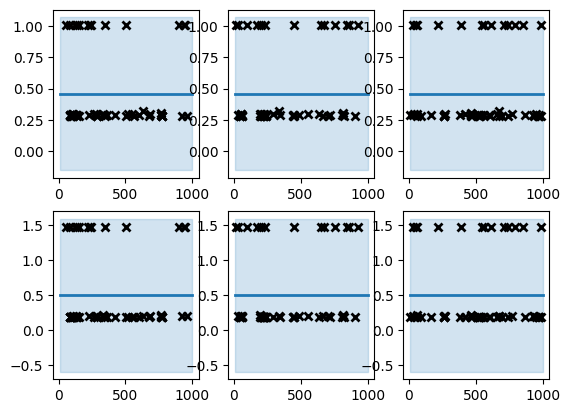

x_best =  [679.46018335 703.16397915 748.6036774 ]
acq_best =  [0.12119387 0.21745881]
C = [680, 703, 0.3743018386981141]
Epoch 1/6
517/517 [==============================] - 7s 10ms/step - loss: 39979134976.0000 - mae: 206014.0312 - mse: 106809237504.0000 - val_loss: 23510181888.0000 - val_mae: 173109.9062 - val_mse: 62810296320.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 22696030208.0000 - mae: 162920.4375 - mse: 60635193344.0000 - val_loss: 20258082816.0000 - val_mae: 153133.3594 - val_mse: 54121902080.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 21647413248.0000 - mae: 159876.1250 - mse: 57833713664.0000 - val_loss: 20579219456.0000 - val_mae: 162648.7656 - val_mse: 54979858432.0000
Epoch 4/6
517/517 [==============================] - 3s 7ms/step - loss: 21459212288.0000 - mae: 159337.9688 - mse: 57330917376.0000 - val_loss: 20242438144.0000 - val_mae: 149636.9844 - val_mse: 54080114688.0000
Epoch 5/6
517/517 [=====

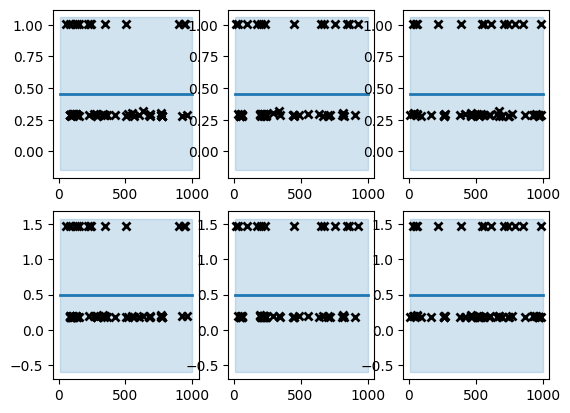

x_best =  [369.29790136 648.13201    544.05567329]
acq_best =  [0.12044514 0.21608782]
C = [370, 649, 0.2720278366442265]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 31776874496.0000 - mae: 214857.9375 - mse: 116814094336.0000 - val_loss: 18337521664.0000 - val_mae: 161798.7500 - val_mse: 67409842176.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 17008244736.0000 - mae: 165746.2969 - mse: 62523293696.0000 - val_loss: 14862907392.0000 - val_mae: 154611.9844 - val_mse: 54636871680.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 15931929600.0000 - mae: 161272.8750 - mse: 58566668288.0000 - val_loss: 15272580096.0000 - val_mae: 162440.3125 - val_mse: 56142843904.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 15541272576.0000 - mae: 159449.7188 - mse: 57130602496.0000 - val_loss: 14936589312.0000 - val_mae: 156473.7656 - val_mse: 54907736064.0000
Epoch 5/6
517/517 [======

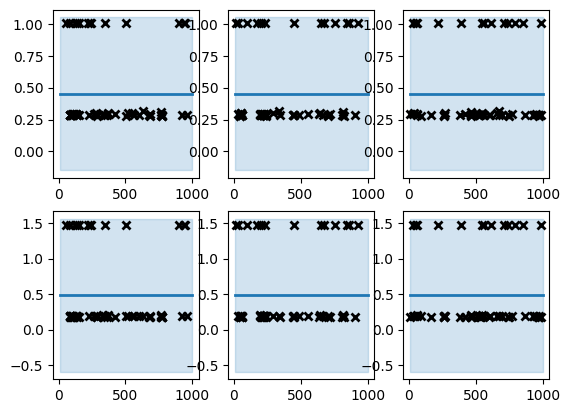

x_best =  [485.89690556 586.57286073 389.70175866]
acq_best =  [0.11963999 0.21461914]
C = [486, 586, 0.19485087933199027]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 21663852544.0000 - mae: 211488.8594 - mse: 111180627968.0000 - val_loss: 12614455296.0000 - val_mae: 161364.3125 - val_mse: 64738193408.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 11853599744.0000 - mae: 163688.0312 - mse: 60833341440.0000 - val_loss: 11475221504.0000 - val_mae: 159433.0312 - val_mse: 58891522048.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 11439669248.0000 - mae: 161324.4531 - mse: 58709053440.0000 - val_loss: 10746554368.0000 - val_mae: 152166.3281 - val_mse: 55151939584.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 11261970432.0000 - mae: 159981.3125 - mse: 57797033984.0000 - val_loss: 10499893248.0000 - val_mae: 154619.8438 - val_mse: 53886029824.0000
Epoch 5/6
517/517 [=====

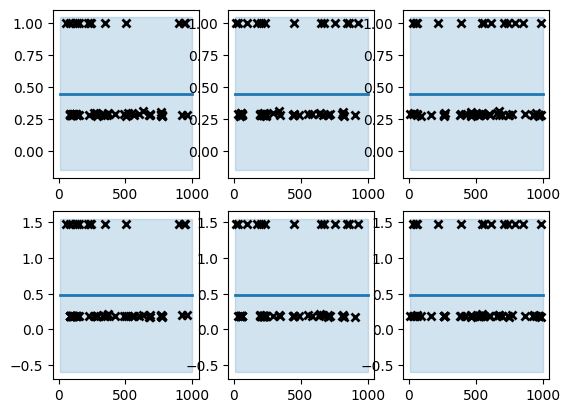

x_best =  [841.95709852  45.22204976 255.95448259]
acq_best =  [0.11885819 0.21326401]
C = [842, 46, 0.1279772412948234]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 15841391616.0000 - mae: 224510.5156 - mse: 123781177344.0000 - val_loss: 11004615680.0000 - val_mae: 174367.1406 - val_mse: 85987500032.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 8489543680.0000 - mae: 165796.7812 - mse: 66335072256.0000 - val_loss: 8477907456.0000 - val_mae: 183881.4375 - val_mse: 66243985408.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 7708866560.0000 - mae: 162842.1406 - mse: 60234948608.0000 - val_loss: 7114579456.0000 - val_mae: 153697.1094 - val_mse: 55591321600.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 7476900864.0000 - mae: 160030.6250 - mse: 58422423552.0000 - val_loss: 7009292800.0000 - val_mae: 159398.7500 - val_mse: 54768594944.0000
Epoch 5/6
517/517 [=============

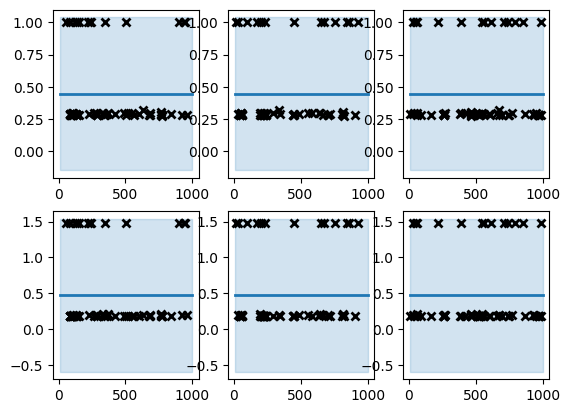

x_best =  [267.00205352 166.80905508 615.54150169]
acq_best =  [0.11811974 0.21195413]
C = [267, 167, 0.30777075084533495]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 39975989248.0000 - mae: 229539.3750 - mse: 129888075776.0000 - val_loss: 28912877568.0000 - val_mae: 199451.2188 - val_mse: 93942243328.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 22131736576.0000 - mae: 171527.7344 - mse: 71909302272.0000 - val_loss: 18896560128.0000 - val_mae: 159373.6094 - val_mse: 61397626880.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 19089850368.0000 - mae: 164552.4375 - mse: 62025666560.0000 - val_loss: 18610683904.0000 - val_mae: 161355.4219 - val_mse: 60468772864.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 18441222144.0000 - mae: 162267.5156 - mse: 59918196736.0000 - val_loss: 17648820224.0000 - val_mae: 163117.4375 - val_mse: 57343553536.0000
Epoch 5/6
517/517 [=====

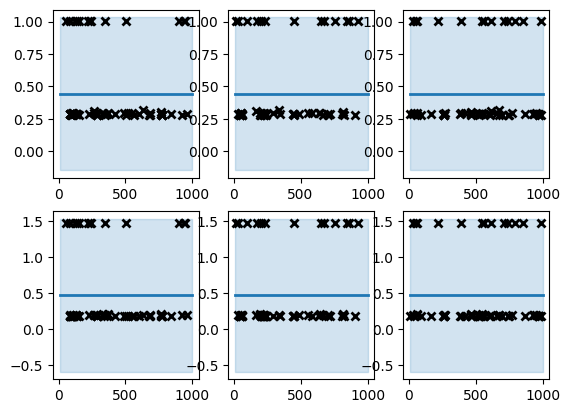

x_best =  [709.2070038  545.99079546 177.45277887]
acq_best =  [0.11731641 0.21061816]
C = [710, 546, 0.088726389436257]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 8923052032.0000 - mae: 203616.2656 - mse: 100565901312.0000 - val_loss: 5182418944.0000 - val_mae: 166745.8438 - val_mse: 58407124992.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 5284347392.0000 - mae: 162688.6562 - mse: 59555950592.0000 - val_loss: 4911895552.0000 - val_mae: 152891.6719 - val_mse: 55358316544.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 5161518080.0000 - mae: 160679.9688 - mse: 58171592704.0000 - val_loss: 5029544960.0000 - val_mae: 153604.7812 - val_mse: 56684261376.0000
Epoch 4/6
517/517 [==============================] - 3s 5ms/step - loss: 5080017408.0000 - mae: 159901.4375 - mse: 57253060608.0000 - val_loss: 4778515968.0000 - val_mae: 152221.5625 - val_mse: 53855051776.0000
Epoch 5/6
517/517 [===============

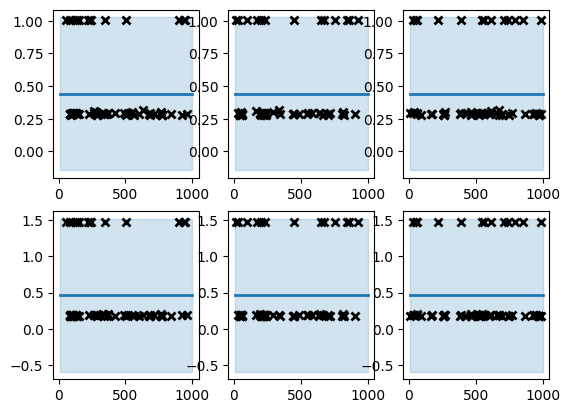

x_best =  [ 61.942624   477.05048237 299.59407439]
acq_best =  [0.11661328 0.20930543]
C = [62, 477, 0.14979703719666582]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 20861120512.0000 - mae: 237389.1094 - mse: 139261001728.0000 - val_loss: 18019176448.0000 - val_mae: 227450.4219 - val_mse: 120289116160.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 15191678976.0000 - mae: 201080.9062 - mse: 101413765120.0000 - val_loss: 10900891648.0000 - val_mae: 168119.7656 - val_mse: 72769961984.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 9603753984.0000 - mae: 164919.1719 - mse: 64110702592.0000 - val_loss: 8312321536.0000 - val_mae: 158002.1719 - val_mse: 55489519616.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 8817069056.0000 - mae: 160677.3281 - mse: 58859073536.0000 - val_loss: 8258066432.0000 - val_mae: 156248.7031 - val_mse: 55127339008.0000
Epoch 5/6
517/517 [========

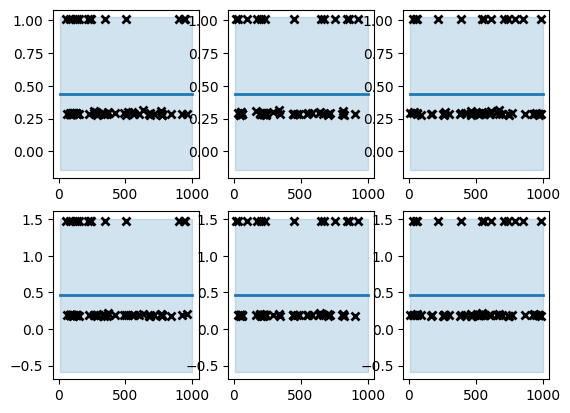

x_best =  [216.23544716 533.34881006 784.72015365]
acq_best =  [0.11592589 0.20802607]
C = [216, 533, 0.3923600768251486]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 48207724544.0000 - mae: 221952.2656 - mse: 122865328128.0000 - val_loss: 31959719936.0000 - val_mae: 178323.1094 - val_mse: 81454628864.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 25838977024.0000 - mae: 166308.1875 - mse: 65854873600.0000 - val_loss: 22587617280.0000 - val_mae: 155535.2500 - val_mse: 57568194560.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 23145592832.0000 - mae: 160791.1875 - mse: 58990268416.0000 - val_loss: 21365217280.0000 - val_mae: 155091.9375 - val_mse: 54452690944.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 22834946048.0000 - mae: 161066.3906 - mse: 58198544384.0000 - val_loss: 21355587584.0000 - val_mae: 151805.5625 - val_mse: 54428180480.0000
Epoch 5/6
517/517 [======

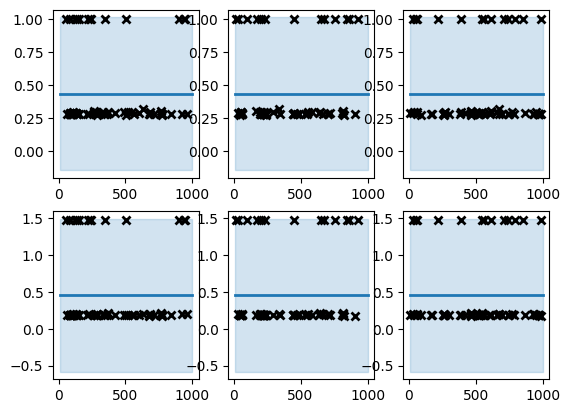

x_best =  [ 66.03468492 351.96080258 543.95124332]
acq_best =  [0.11524369 0.20677987]
C = [66, 352, 0.27197562166127637]
Epoch 1/6
517/517 [==============================] - 4s 4ms/step - loss: 37554786304.0000 - mae: 237686.7969 - mse: 138080583680.0000 - val_loss: 31932477440.0000 - val_mae: 214598.4688 - val_mse: 117408555008.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 24986779648.0000 - mae: 191034.7656 - mse: 91870707712.0000 - val_loss: 17437505536.0000 - val_mae: 166146.5000 - val_mse: 64113594368.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 17064475648.0000 - mae: 163863.6719 - mse: 62742048768.0000 - val_loss: 15476996096.0000 - val_mae: 160227.6719 - val_mse: 56905216000.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 16247062528.0000 - mae: 162249.9531 - mse: 59736596480.0000 - val_loss: 15158737920.0000 - val_mae: 154398.3594 - val_mse: 55735062528.0000
Epoch 5/6
517/517 [=====

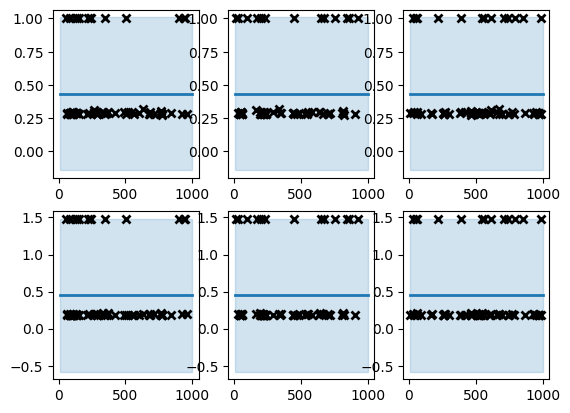

x_best =  [326.84155636 617.12287474 633.56299952]
acq_best =  [0.11454374 0.20551715]
C = [327, 617, 0.3167814997587476]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 38742429696.0000 - mae: 221429.2969 - mse: 122299629568.0000 - val_loss: 25630386176.0000 - val_mae: 187740.0781 - val_mse: 80908132352.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 20363270144.0000 - mae: 165085.4844 - mse: 64281161728.0000 - val_loss: 18121994240.0000 - val_mae: 153313.3438 - val_mse: 57206145024.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 18607409152.0000 - mae: 160800.1250 - mse: 58738434048.0000 - val_loss: 19844777984.0000 - val_mae: 157250.9688 - val_mse: 62644514816.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 18557376512.0000 - mae: 160600.3281 - mse: 58580496384.0000 - val_loss: 17167730688.0000 - val_mae: 159160.0312 - val_mse: 54193725440.0000
Epoch 5/6
517/517 [======

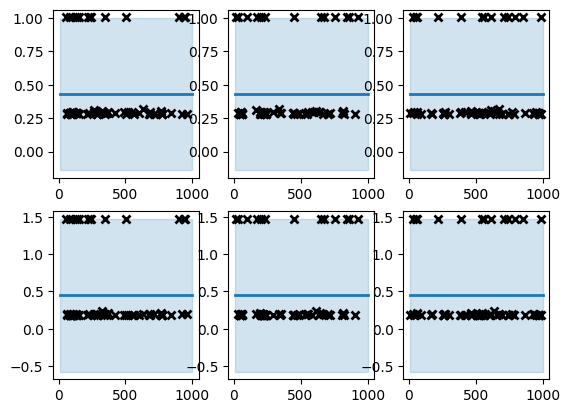

x_best =  [681.14824687 623.74383898  58.3949303 ]
acq_best =  [0.11381567 0.20417487]
C = [681, 624, 0.029197465150614277]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 3056865536.0000 - mae: 205457.5156 - mse: 104689262592.0000 - val_loss: 1837366016.0000 - val_mae: 159741.1562 - val_mse: 62923493376.0000
Epoch 2/6
517/517 [==============================] - 4s 7ms/step - loss: 1774883072.0000 - mae: 163310.3906 - mse: 60783366144.0000 - val_loss: 1652379520.0000 - val_mae: 166363.1562 - val_mse: 56587554816.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 1708717824.0000 - mae: 161611.0312 - mse: 58517307392.0000 - val_loss: 1665305216.0000 - val_mae: 155022.6719 - val_mse: 57030639616.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 1709746688.0000 - mae: 162379.2188 - mse: 58552516608.0000 - val_loss: 1567652608.0000 - val_mae: 153627.6406 - val_mse: 53686140928.0000
Epoch 5/6
517/517 [============

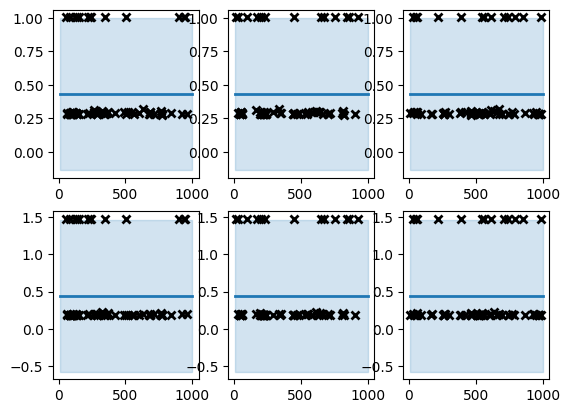

x_best =  [504.83192942 857.67590229 874.66419703]
acq_best =  [0.11311992 0.20297083]
C = [505, 858, 0.4373320985158427]
Epoch 1/6
517/517 [==============================] - 5s 7ms/step - loss: 46342656000.0000 - mae: 208050.3906 - mse: 105966362624.0000 - val_loss: 26216087552.0000 - val_mae: 157996.8125 - val_mse: 59945132032.0000
Epoch 2/6
517/517 [==============================] - 4s 8ms/step - loss: 26765545472.0000 - mae: 163669.0625 - mse: 61201469440.0000 - val_loss: 23507423232.0000 - val_mae: 152112.3594 - val_mse: 53751537664.0000
Epoch 3/6
517/517 [==============================] - 4s 8ms/step - loss: 25335414784.0000 - mae: 159348.4375 - mse: 57931436032.0000 - val_loss: 24450035712.0000 - val_mae: 158508.3750 - val_mse: 55906906112.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 24728031232.0000 - mae: 157693.6562 - mse: 56542531584.0000 - val_loss: 24172306432.0000 - val_mae: 161063.5781 - val_mse: 55271829504.0000
Epoch 5/6
517/517 [======

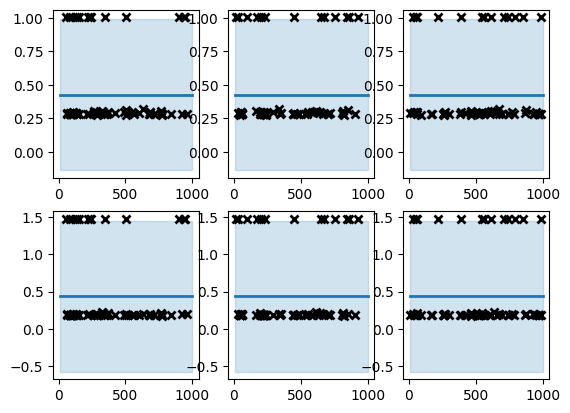

x_best =  [959.54590347 628.16161504 420.29900032]
acq_best =  [0.11240446 0.20177894]
C = [959, 629, 0.21014950015952719]
Epoch 1/6
517/517 [==============================] - 7s 11ms/step - loss: 88902336512.0000 - mae: 538371.5000 - mse: 423040843776.0000 - val_loss: 90373881856.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 88902320128.0000 - mae: 538371.4375 - mse: 423040909312.0000 - val_loss: 90373881856.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 88902320128.0000 - mae: 538371.5625 - mse: 423040581632.0000 - val_loss: 90373881856.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 6s 11ms/step - loss: 88902352896.0000 - mae: 538371.2500 - mse: 423040385024.0000 - val_loss: 90373881856.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517

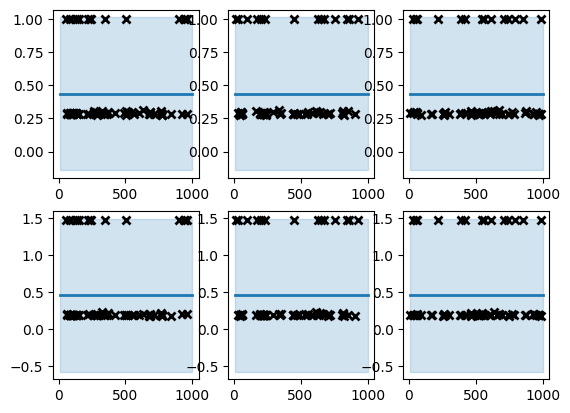

x_best =  [233.23814678 738.85268663 855.18583573]
acq_best =  [0.11502851 0.2064935 ]
C = [234, 738, 0.42759291786337483]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 50912448512.0000 - mae: 220580.1562 - mse: 119067090944.0000 - val_loss: 34750390272.0000 - val_mae: 172072.5156 - val_mse: 81269407744.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 27323240448.0000 - mae: 166197.8594 - mse: 63899742208.0000 - val_loss: 23501932544.0000 - val_mae: 155346.1719 - val_mse: 54962974720.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 25152600064.0000 - mae: 161122.8438 - mse: 58823311360.0000 - val_loss: 22850301952.0000 - val_mae: 155098.3750 - val_mse: 53439004672.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 24711837696.0000 - mae: 160435.2344 - mse: 57792544768.0000 - val_loss: 23575560192.0000 - val_mae: 153256.2969 - val_mse: 55135174656.0000
Epoch 5/6
517/517 [=====

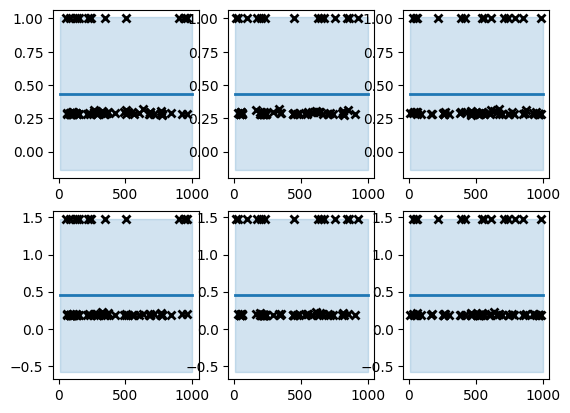

x_best =  [218.28474494 414.94120833 657.76994921]
acq_best =  [0.11441551 0.20535828]
C = [218, 415, 0.32888497460626887]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 40943800320.0000 - mae: 223704.4219 - mse: 124492144640.0000 - val_loss: 26905200640.0000 - val_mae: 180153.2500 - val_mse: 81806770176.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 22023962624.0000 - mae: 167645.7500 - mse: 66965061632.0000 - val_loss: 19102148608.0000 - val_mae: 155731.7656 - val_mse: 58081095680.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 19772022784.0000 - mae: 162419.5781 - mse: 60117917696.0000 - val_loss: 19834445824.0000 - val_mae: 164929.6250 - val_mse: 60307652608.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 19119251456.0000 - mae: 160048.7656 - mse: 58133086208.0000 - val_loss: 18609893376.0000 - val_mae: 158989.9531 - val_mse: 56584310784.0000
Epoch 5/6
517/517 [=====

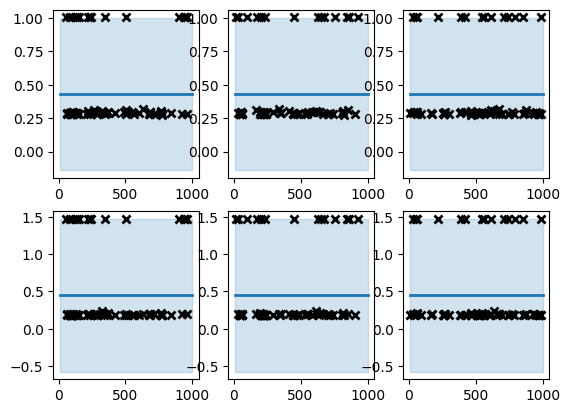

x_best =  [926.68201924 572.17875528 494.4789894 ]
acq_best =  [0.1137512  0.20422425]
C = [927, 572, 0.24723949469912412]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 104592949248.0000 - mae: 538371.6875 - mse: 423040778240.0000 - val_loss: 106324148224.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 104592842752.0000 - mae: 538371.6875 - mse: 423040712704.0000 - val_loss: 106324148224.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 104592949248.0000 - mae: 538371.5625 - mse: 423040811008.0000 - val_loss: 106324148224.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 4s 8ms/step - loss: 104592916480.0000 - mae: 538371.5000 - mse: 423040811008.0000 - val_loss: 106324148224.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/

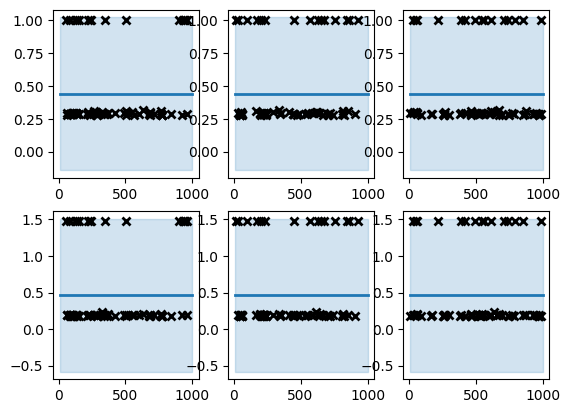

x_best =  [966.86267464 594.83595736 311.35207697]
acq_best =  [0.11616952 0.20857001]
C = [967, 594, 0.15567603848738668]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 65857835008.0000 - mae: 538371.5625 - mse: 423040712704.0000 - val_loss: 66947923968.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 65857830912.0000 - mae: 538371.6250 - mse: 423040581632.0000 - val_loss: 66947923968.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 65857859584.0000 - mae: 538371.4375 - mse: 423040712704.0000 - val_loss: 66947923968.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 5s 9ms/step - loss: 65857818624.0000 - mae: 538371.6250 - mse: 423040614400.0000 - val_loss: 66947923968.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/

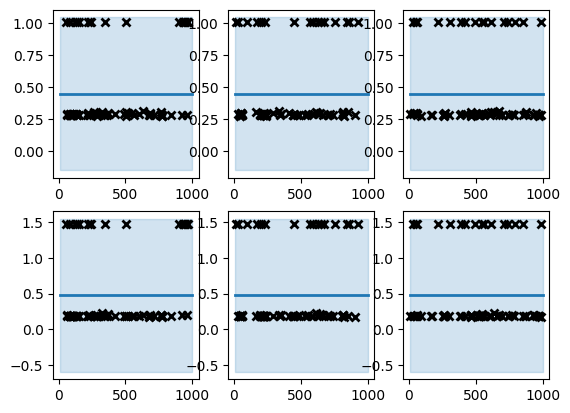

x_best =  [220.0032815  995.01373506 975.46174378]
acq_best =  [0.11838748 0.21255534]
C = [220, 995, 0.4877308718917393]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 60015460352.0000 - mae: 222844.0000 - mse: 123049893888.0000 - val_loss: 38732201984.0000 - val_mae: 202634.5781 - val_mse: 79412649984.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 32026386432.0000 - mae: 168261.9219 - mse: 65663721472.0000 - val_loss: 31818700800.0000 - val_mae: 182340.4688 - val_mse: 65237864448.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 29207189504.0000 - mae: 162595.1250 - mse: 59883474944.0000 - val_loss: 26592102400.0000 - val_mae: 153441.2344 - val_mse: 54521765888.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 28648228864.0000 - mae: 161108.3281 - mse: 58737442816.0000 - val_loss: 26971697152.0000 - val_mae: 162724.3906 - val_mse: 55300038656.0000
Epoch 5/6
517/517 [======

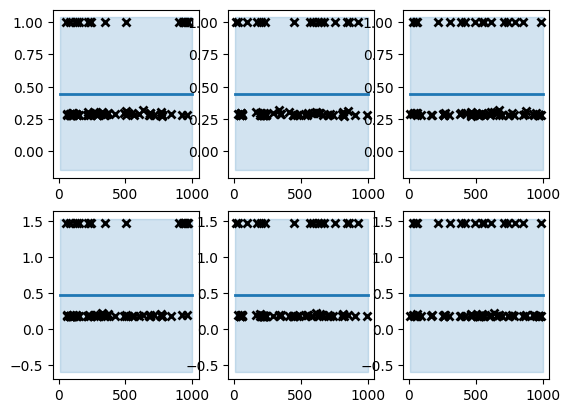

x_best =  [972.71189517 745.35040271 820.43955987]
acq_best =  [0.11780689 0.21149743]
C = [973, 745, 0.4102197799341115]
Epoch 1/6
517/517 [==============================] - 5s 8ms/step - loss: 40735776768.0000 - mae: 202594.9219 - mse: 99301695488.0000 - val_loss: 27120824320.0000 - val_mae: 190542.9219 - val_mse: 66112442368.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 24794368000.0000 - mae: 163159.5625 - mse: 60441272320.0000 - val_loss: 23291674624.0000 - val_mae: 154834.9688 - val_mse: 56778133504.0000
Epoch 3/6
517/517 [==============================] - 7s 14ms/step - loss: 23966210048.0000 - mae: 159821.4375 - mse: 58422476800.0000 - val_loss: 23113840640.0000 - val_mae: 154708.0625 - val_mse: 56344645632.0000
Epoch 4/6
517/517 [==============================] - 7s 13ms/step - loss: 23432040448.0000 - mae: 158665.0156 - mse: 57120272384.0000 - val_loss: 21910511616.0000 - val_mae: 152855.2656 - val_mse: 53411278848.0000
Epoch 5/6
517/517 [====

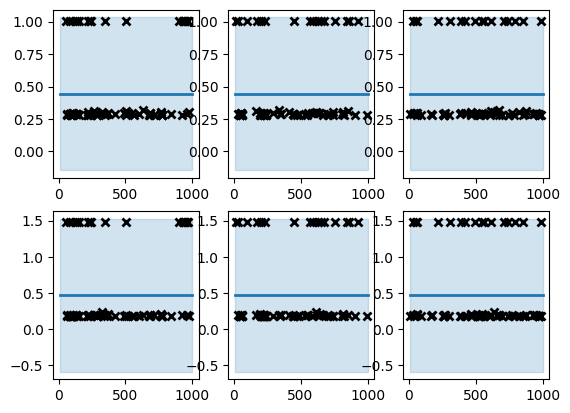

x_best =  [ 75.13234127 396.97661198 166.28227996]
acq_best =  [0.11718423 0.21044003]
C = [75, 397, 0.08314113998189329]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 11452727296.0000 - mae: 237275.8594 - mse: 137747546112.0000 - val_loss: 9676953600.0000 - val_mae: 211808.3438 - val_mse: 116389339136.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 7451846656.0000 - mae: 190326.8438 - mse: 89626697728.0000 - val_loss: 5207351808.0000 - val_mae: 159063.6250 - val_mse: 62630772736.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 5132893696.0000 - mae: 163194.5938 - mse: 61735120896.0000 - val_loss: 4644195328.0000 - val_mae: 155763.9062 - val_mse: 55857274880.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 4952043520.0000 - mae: 161816.8906 - mse: 59559968768.0000 - val_loss: 4655862272.0000 - val_mae: 159051.0000 - val_mse: 55997579264.0000
Epoch 5/6
517/517 [============

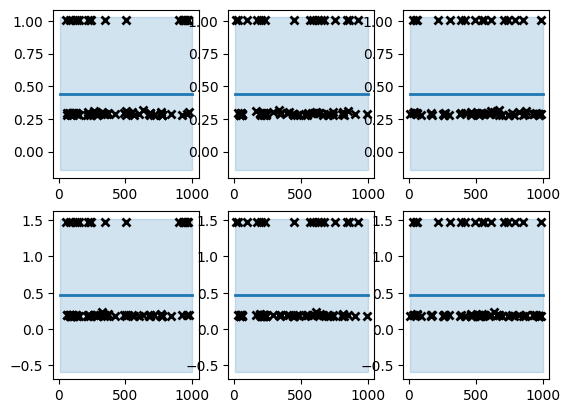

x_best =  [375.11468273 256.35675552 613.6827146 ]
acq_best =  [0.1165947  0.20939828]
C = [375, 257, 0.3068413573021247]
Epoch 1/6
517/517 [==============================] - 4s 4ms/step - loss: 38336585728.0000 - mae: 225377.4688 - mse: 124938715136.0000 - val_loss: 26286065664.0000 - val_mae: 180975.4688 - val_mse: 85666078720.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 20569317376.0000 - mae: 168329.5781 - mse: 67035123712.0000 - val_loss: 17195757568.0000 - val_mae: 159557.6719 - val_mse: 56040669184.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 18177200128.0000 - mae: 161685.3281 - mse: 59239219200.0000 - val_loss: 18868910080.0000 - val_mae: 179785.3906 - val_mse: 61493428224.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 17786685440.0000 - mae: 159737.2188 - mse: 57966522368.0000 - val_loss: 16793355264.0000 - val_mae: 160053.4688 - val_mse: 54729256960.0000
Epoch 5/6
517/517 [======

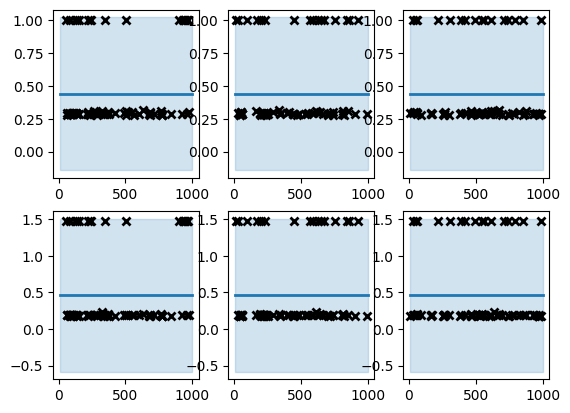

x_best =  [468.66089402 688.77421982 999.9818137 ]
acq_best =  [0.11603142 0.20838006]
C = [469, 689, 0.49999090685120334]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 54939312128.0000 - mae: 209637.3281 - mse: 109880279040.0000 - val_loss: 31915114496.0000 - val_mae: 159470.7656 - val_mse: 63831072768.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 30333925376.0000 - mae: 163015.0781 - mse: 60668669952.0000 - val_loss: 28512722944.0000 - val_mae: 158334.2031 - val_mse: 57026166784.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 29023346688.0000 - mae: 160795.1719 - mse: 58047385600.0000 - val_loss: 29626550272.0000 - val_mae: 163382.3438 - val_mse: 59253841920.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 29047775232.0000 - mae: 159771.4375 - mse: 58096279552.0000 - val_loss: 26600634368.0000 - val_mae: 152411.3594 - val_mse: 53201956864.0000
Epoch 5/6
517/517 [=====

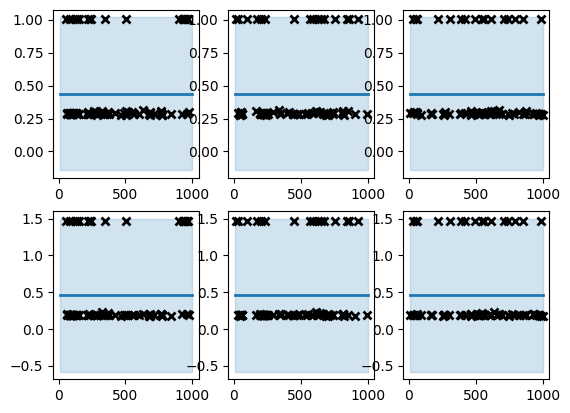

x_best =  [356.10203124 978.93094942 294.89628338]
acq_best =  [0.11549841 0.20737957]
C = [357, 979, 0.14744814168833256]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 16736174080.0000 - mae: 211114.5312 - mse: 113504108544.0000 - val_loss: 9216836608.0000 - val_mae: 159883.5312 - val_mse: 62507909120.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 9064060928.0000 - mae: 164213.6875 - mse: 61471752192.0000 - val_loss: 8060148736.0000 - val_mae: 154998.1875 - val_mse: 54663233536.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 8580391936.0000 - mae: 160386.0312 - mse: 58191527936.0000 - val_loss: 8383752704.0000 - val_mae: 159255.0156 - val_mse: 56857911296.0000
Epoch 4/6
517/517 [==============================] - 4s 7ms/step - loss: 8430834688.0000 - mae: 159055.1406 - mse: 57177255936.0000 - val_loss: 7871496192.0000 - val_mae: 152525.7031 - val_mse: 53383802880.0000
Epoch 5/6
517/517 [============

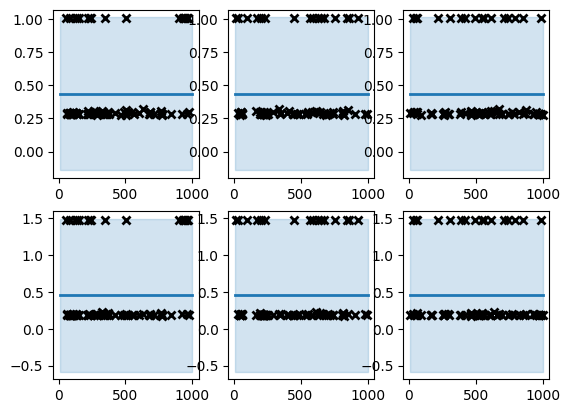

x_best =  [600.06761623 620.02021175 974.59074578]
acq_best =  [0.11494536 0.20634558]
C = [600, 620, 0.4872953728879676]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 53450739712.0000 - mae: 210879.9219 - mse: 109688160256.0000 - val_loss: 29759578112.0000 - val_mae: 163764.4688 - val_mse: 61070573568.0000
Epoch 2/6
517/517 [==============================] - 3s 6ms/step - loss: 29785307136.0000 - mae: 162810.8906 - mse: 61123407872.0000 - val_loss: 26866800640.0000 - val_mae: 160343.6562 - val_mse: 55134175232.0000
Epoch 3/6
517/517 [==============================] - 4s 7ms/step - loss: 28173176832.0000 - mae: 159394.3438 - mse: 57815080960.0000 - val_loss: 28421074944.0000 - val_mae: 154641.0156 - val_mse: 58323812352.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 27961300992.0000 - mae: 158843.0469 - mse: 57380249600.0000 - val_loss: 28377921536.0000 - val_mae: 168130.7188 - val_mse: 58235244544.0000
Epoch 5/6
517/517 [======

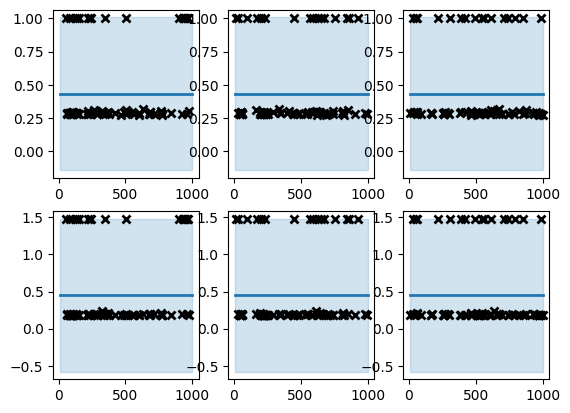

x_best =  [387.06547215 712.59294265 309.10083081]
acq_best =  [0.11442136 0.2053664 ]
C = [387, 713, 0.1545504154067883]
Epoch 1/6
517/517 [==============================] - 4s 6ms/step - loss: 17498617856.0000 - mae: 214607.8750 - mse: 113221337088.0000 - val_loss: 9600873472.0000 - val_mae: 160333.1875 - val_mse: 62120259584.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 9468666880.0000 - mae: 164064.2188 - mse: 61264764928.0000 - val_loss: 8741706752.0000 - val_mae: 165650.7188 - val_mse: 56561090560.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 9055642624.0000 - mae: 161157.0781 - mse: 58592436224.0000 - val_loss: 8687594496.0000 - val_mae: 162207.9688 - val_mse: 56210980864.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 8935511040.0000 - mae: 160255.3438 - mse: 57815093248.0000 - val_loss: 9324491776.0000 - val_mae: 156943.0469 - val_mse: 60332003328.0000
Epoch 5/6
517/517 [=============

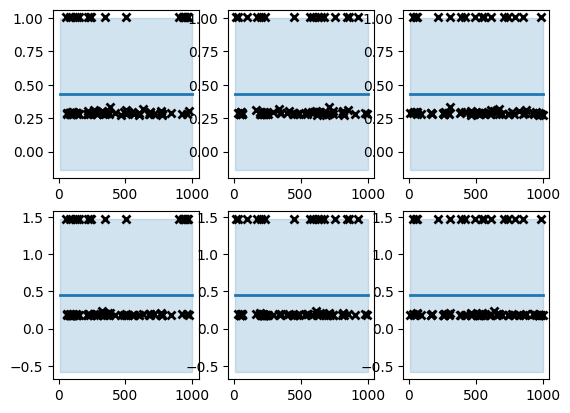

x_best =  [802.1299927   86.35334999 284.34158392]
acq_best =  [0.11378035 0.20433304]
C = [802, 87, 0.1421707919586957]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 60144566272.0000 - mae: 538371.5000 - mse: 423040188416.0000 - val_loss: 61140094976.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 60144570368.0000 - mae: 538371.5625 - mse: 423041073152.0000 - val_loss: 61140094976.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 60144578560.0000 - mae: 538371.4375 - mse: 423040811008.0000 - val_loss: 61140094976.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 60144582656.0000 - mae: 538371.3125 - mse: 423040548864.0000 - val_loss: 61140094976.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/517 [

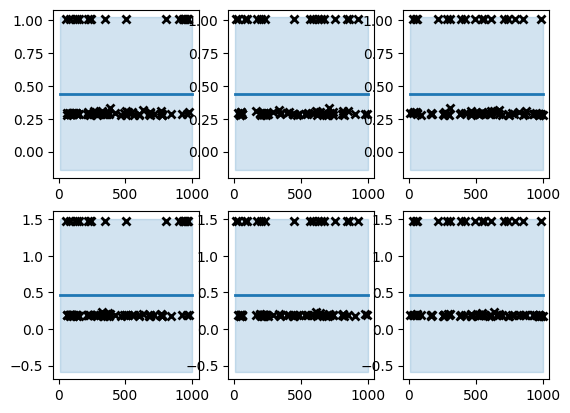

x_best =  [596.0697668  132.14517616 856.53336853]
acq_best =  [0.11589798 0.20814066]
C = [596, 132, 0.42826668426666636]
Epoch 1/6
517/517 [==============================] - 3s 4ms/step - loss: 52946239488.0000 - mae: 224158.2344 - mse: 123628666880.0000 - val_loss: 32846485504.0000 - val_mae: 173787.4688 - val_mse: 76695945216.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 27668135936.0000 - mae: 165630.3125 - mse: 64604573696.0000 - val_loss: 23942311936.0000 - val_mae: 159790.0625 - val_mse: 55904772096.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 25496438784.0000 - mae: 162344.5781 - mse: 59533651968.0000 - val_loss: 23135633408.0000 - val_mae: 153153.7812 - val_mse: 54021210112.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 24909176832.0000 - mae: 160023.3438 - mse: 58162405376.0000 - val_loss: 24326082560.0000 - val_mae: 152393.8906 - val_mse: 56800903168.0000
Epoch 5/6
517/517 [=====

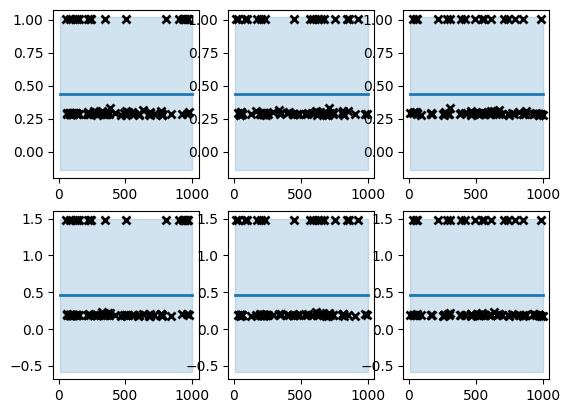

x_best =  [116.12079668  98.83190594 785.44853289]
acq_best =  [0.11538295 0.20720755]
C = [116, 99, 0.3927242664453916]
Epoch 1/6
517/517 [==============================] - 1s 2ms/step - loss: 57698820096.0000 - mae: 246579.4688 - mse: 146918801408.0000 - val_loss: 47459790848.0000 - val_mae: 243889.3906 - val_mse: 120847024128.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 38221103104.0000 - mae: 196296.9219 - mse: 97322467328.0000 - val_loss: 27779461120.0000 - val_mae: 168824.3281 - val_mse: 70734856192.0000
Epoch 3/6
517/517 [==============================] - 1s 1ms/step - loss: 25769728000.0000 - mae: 165225.4531 - mse: 65617477632.0000 - val_loss: 22770237440.0000 - val_mae: 160399.0938 - val_mse: 57979793408.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 24008732672.0000 - mae: 162841.2344 - mse: 61133381632.0000 - val_loss: 22700607488.0000 - val_mae: 161412.3438 - val_mse: 57802510336.0000
Epoch 5/6
517/517 [======

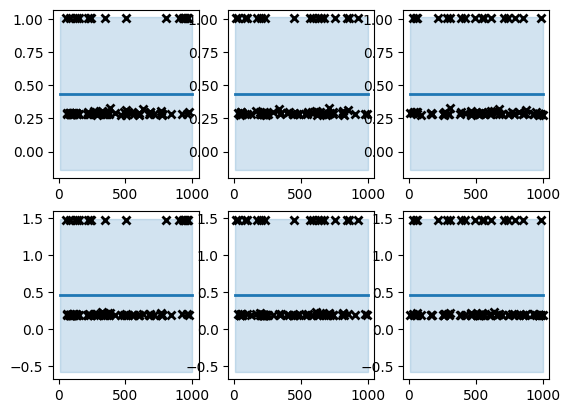

x_best =  [725.16802732 984.82887886 854.44389825]
acq_best =  [0.11486321 0.2062494 ]
C = [725, 985, 0.4272219491244694]
Epoch 1/6
517/517 [==============================] - 6s 10ms/step - loss: 180732657664.0000 - mae: 538371.7500 - mse: 423040811008.0000 - val_loss: 183724359680.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 5s 10ms/step - loss: 180732854272.0000 - mae: 538371.6250 - mse: 423040614400.0000 - val_loss: 183724359680.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 5s 10ms/step - loss: 180732821504.0000 - mae: 538371.5625 - mse: 423040909312.0000 - val_loss: 183724359680.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 6s 12ms/step - loss: 180732755968.0000 - mae: 538371.1250 - mse: 423040647168.0000 - val_loss: 183724359680.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 

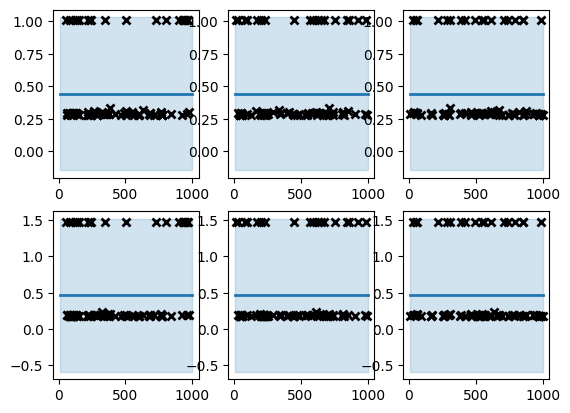

x_best =  [926.65204524 770.42748906 249.91330774]
acq_best =  [0.11684316 0.20980861]
C = [927, 770, 0.1249566538678184]
Epoch 1/6
517/517 [==============================] - 7s 12ms/step - loss: 12919096320.0000 - mae: 203568.3750 - mse: 103386947584.0000 - val_loss: 7724724224.0000 - val_mae: 156897.2656 - val_mse: 61817987072.0000
Epoch 2/6
517/517 [==============================] - 6s 11ms/step - loss: 7596817408.0000 - mae: 164355.6406 - mse: 60794290176.0000 - val_loss: 6743311872.0000 - val_mae: 154194.5781 - val_mse: 53963972608.0000
Epoch 3/6
517/517 [==============================] - 6s 11ms/step - loss: 7389069824.0000 - mae: 161425.1875 - mse: 59131752448.0000 - val_loss: 6922031104.0000 - val_mae: 160053.6094 - val_mse: 55394205696.0000
Epoch 4/6
517/517 [==============================] - 6s 11ms/step - loss: 7160679424.0000 - mae: 159058.6094 - mse: 57304014848.0000 - val_loss: 7403964928.0000 - val_mae: 163290.9062 - val_mse: 59250950144.0000
Epoch 5/6
517/517 [=========

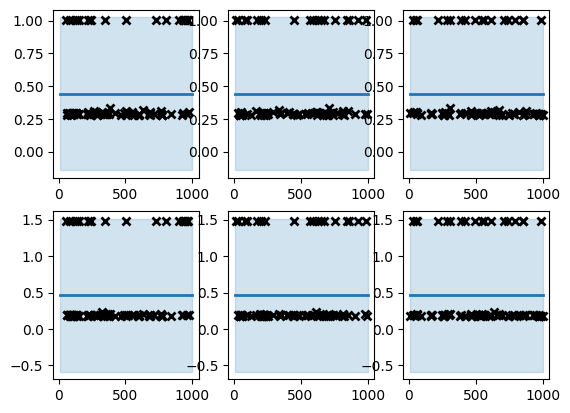

x_best =  [193.94971876 690.15663486 501.21090947]
acq_best =  [0.11631038 0.20889111]
C = [194, 690, 0.25060545473311563]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 31780345856.0000 - mae: 227822.0156 - mse: 126813364224.0000 - val_loss: 23736190976.0000 - val_mae: 192703.5000 - val_mse: 94714634240.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 17534504960.0000 - mae: 169902.5625 - mse: 69967896576.0000 - val_loss: 14378173440.0000 - val_mae: 158422.0469 - val_mse: 57373122560.0000
Epoch 3/6
517/517 [==============================] - 3s 5ms/step - loss: 14819161088.0000 - mae: 160996.9375 - mse: 59132768256.0000 - val_loss: 13999076352.0000 - val_mae: 153449.4688 - val_mse: 55860396032.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 14394507264.0000 - mae: 158720.5156 - mse: 57438298112.0000 - val_loss: 13412081664.0000 - val_mae: 153727.5312 - val_mse: 53518118912.0000
Epoch 5/6
517/517 [=====

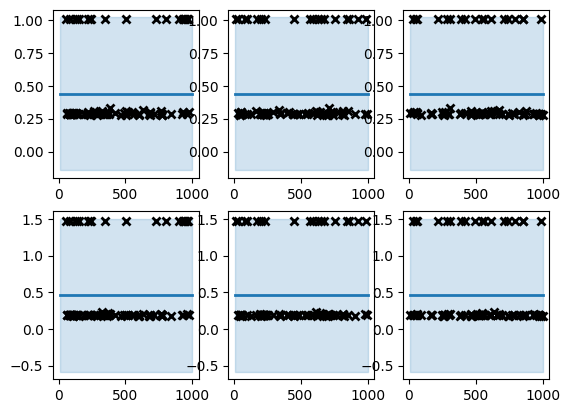

x_best =  [680.53537349 539.75545595 935.54524013]
acq_best =  [0.11581728 0.20798901]
C = [680, 540, 0.4677726200667376]
Epoch 1/6
517/517 [==============================] - 4s 5ms/step - loss: 48078032896.0000 - mae: 203851.7344 - mse: 102780321792.0000 - val_loss: 29640683520.0000 - val_mae: 174307.9531 - val_mse: 63365197824.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 28420845568.0000 - mae: 164058.4688 - mse: 60757491712.0000 - val_loss: 26438156288.0000 - val_mae: 153581.4375 - val_mse: 56518909952.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 27534981120.0000 - mae: 161364.8281 - mse: 58863661056.0000 - val_loss: 25420337152.0000 - val_mae: 152965.9844 - val_mse: 54343028736.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 26976704512.0000 - mae: 160364.2188 - mse: 57670234112.0000 - val_loss: 25158223872.0000 - val_mae: 151370.2344 - val_mse: 53782695936.0000
Epoch 5/6
517/517 [======

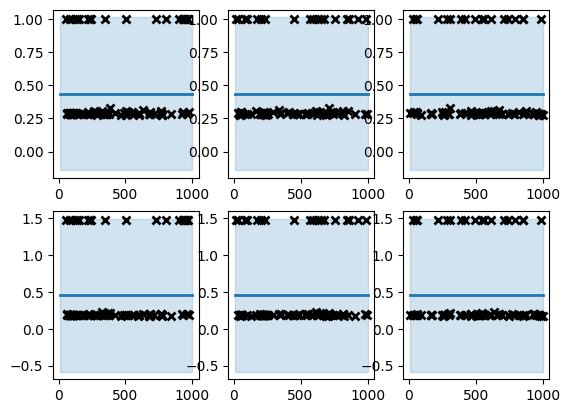

x_best =  [144.20820524 583.4987469  474.28767072]
acq_best =  [0.11533147 0.20706207]
C = [144, 584, 0.23714383536239625]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 29859807232.0000 - mae: 226130.5156 - mse: 125913391104.0000 - val_loss: 20625321984.0000 - val_mae: 180972.0469 - val_mse: 86973095936.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 16144149504.0000 - mae: 169119.0781 - mse: 68076752896.0000 - val_loss: 15084953600.0000 - val_mae: 163413.1094 - val_mse: 63610302464.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 14209658880.0000 - mae: 162454.1250 - mse: 59919319040.0000 - val_loss: 14020457472.0000 - val_mae: 170496.3281 - val_mse: 59121467392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 13715108864.0000 - mae: 160476.9062 - mse: 57833852928.0000 - val_loss: 13985818624.0000 - val_mae: 157907.1094 - val_mse: 58975465472.0000
Epoch 5/6
517/517 [=====

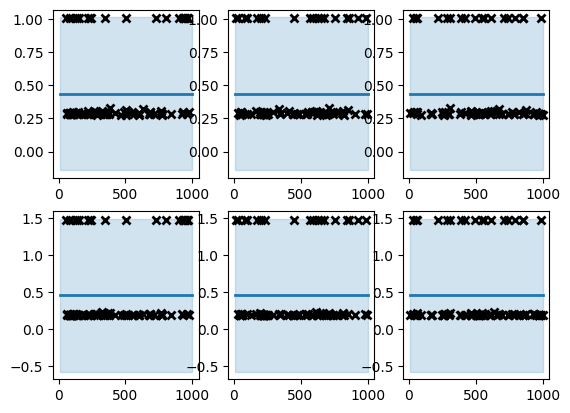

x_best =  [367.17804208 633.23627069 283.30290901]
acq_best =  [0.11481413 0.20616718]
C = [367, 634, 0.14165145450668037]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 16468870144.0000 - mae: 215441.6406 - mse: 116261904384.0000 - val_loss: 9635737600.0000 - val_mae: 160691.3281 - val_mse: 68023148544.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 8609085440.0000 - mae: 162745.0938 - mse: 60775399424.0000 - val_loss: 7739681792.0000 - val_mae: 158277.2500 - val_mse: 54637797376.0000
Epoch 3/6
517/517 [==============================] - 1s 3ms/step - loss: 8227828736.0000 - mae: 160515.0000 - mse: 58083905536.0000 - val_loss: 7784825344.0000 - val_mae: 161216.3438 - val_mse: 54956449792.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 8200624128.0000 - mae: 159512.5469 - mse: 57891864576.0000 - val_loss: 8327729664.0000 - val_mae: 157373.8594 - val_mse: 58789175296.0000
Epoch 5/6
517/517 [============

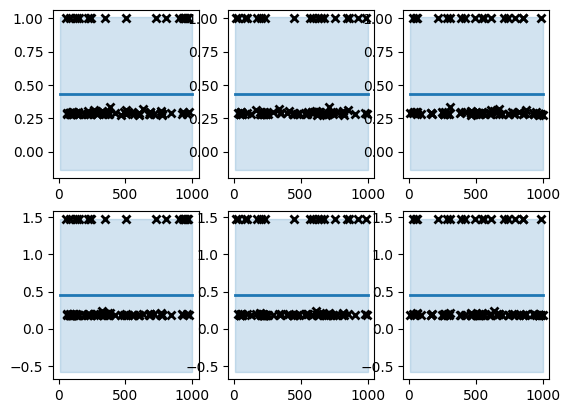

x_best =  [945.31013386 238.37313748 379.03448996]
acq_best =  [0.1143479  0.20529591]
C = [946, 239, 0.18951724497871694]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 21001566208.0000 - mae: 208754.0156 - mse: 110815117312.0000 - val_loss: 11765515264.0000 - val_mae: 160625.3594 - val_mse: 62080626688.0000
Epoch 2/6
517/517 [==============================] - 1s 3ms/step - loss: 11909330944.0000 - mae: 164125.7500 - mse: 62839484416.0000 - val_loss: 10816930816.0000 - val_mae: 164052.6562 - val_mse: 57075372032.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 11232679936.0000 - mae: 161642.6250 - mse: 59269083136.0000 - val_loss: 10298840064.0000 - val_mae: 153566.2500 - val_mse: 54341685248.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 10910878720.0000 - mae: 158697.3750 - mse: 57571078144.0000 - val_loss: 10238124032.0000 - val_mae: 155888.4062 - val_mse: 54021292032.0000
Epoch 5/6
517/517 [=====

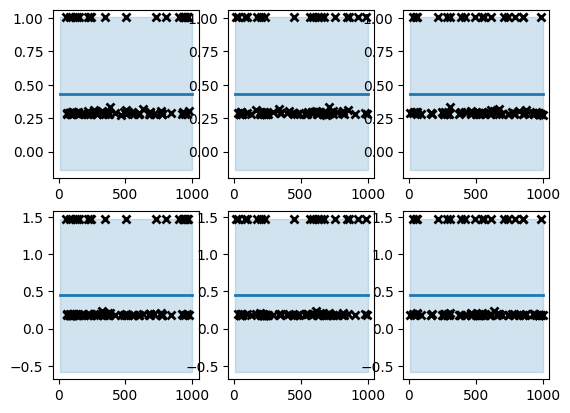

x_best =  [868.37876626 500.8724413  409.62715105]
acq_best =  [0.11388235 0.2044482 ]
C = [868, 501, 0.2048135755269334]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 22340106240.0000 - mae: 210501.8281 - mse: 109074341888.0000 - val_loss: 12534075392.0000 - val_mae: 156646.8906 - val_mse: 61196746752.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 12645563392.0000 - mae: 163848.8281 - mse: 61741031424.0000 - val_loss: 11273001984.0000 - val_mae: 154477.7344 - val_mse: 55039569920.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 11964181504.0000 - mae: 160385.4844 - mse: 58414174208.0000 - val_loss: 11302037504.0000 - val_mae: 151667.0312 - val_mse: 55181332480.0000
Epoch 4/6
517/517 [==============================] - 2s 4ms/step - loss: 11844850688.0000 - mae: 159321.6094 - mse: 57831596032.0000 - val_loss: 13588141056.0000 - val_mae: 189983.5156 - val_mse: 66343038976.0000
Epoch 5/6
517/517 [======

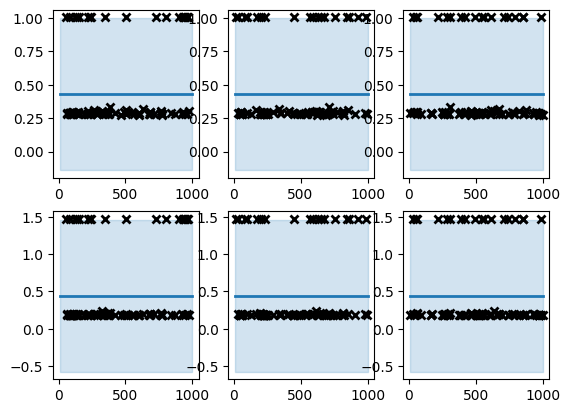

x_best =  [483.01710434 669.63620962 744.34917026]
acq_best =  [0.11341916 0.20359735]
C = [484, 670, 0.37217458512821106]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 40453795840.0000 - mae: 208026.5312 - mse: 108695060480.0000 - val_loss: 22797434880.0000 - val_mae: 166293.7188 - val_mse: 61254242304.0000
Epoch 2/6
517/517 [==============================] - 2s 3ms/step - loss: 22909960192.0000 - mae: 163659.5625 - mse: 61556629504.0000 - val_loss: 19903223808.0000 - val_mae: 153705.6719 - val_mse: 53477773312.0000
Epoch 3/6
517/517 [==============================] - 2s 3ms/step - loss: 21570119680.0000 - mae: 160488.4219 - mse: 57956560896.0000 - val_loss: 20429025280.0000 - val_mae: 154761.5781 - val_mse: 54890561536.0000
Epoch 4/6
517/517 [==============================] - 2s 3ms/step - loss: 21529145344.0000 - mae: 159238.1562 - mse: 57846444032.0000 - val_loss: 20908816384.0000 - val_mae: 151358.0312 - val_mse: 56179720192.0000
Epoch 5/6
517/517 [=====

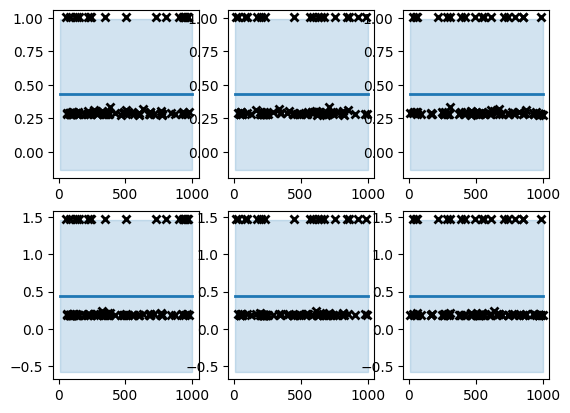

x_best =  [947.32238954 265.42669902  49.08283612]
acq_best =  [0.11294506 0.20275988]
C = [948, 265, 0.024541418061954347]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 10382557184.0000 - mae: 538371.3125 - mse: 423040876544.0000 - val_loss: 10554407936.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 2s 4ms/step - loss: 10382557184.0000 - mae: 538371.5625 - mse: 423040778240.0000 - val_loss: 10554407936.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 2s 4ms/step - loss: 10382556160.0000 - mae: 538371.4375 - mse: 423040679936.0000 - val_loss: 10554407936.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 2s 5ms/step - loss: 10382550016.0000 - mae: 538371.4375 - mse: 423040712704.0000 - val_loss: 10554407936.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6
517/51

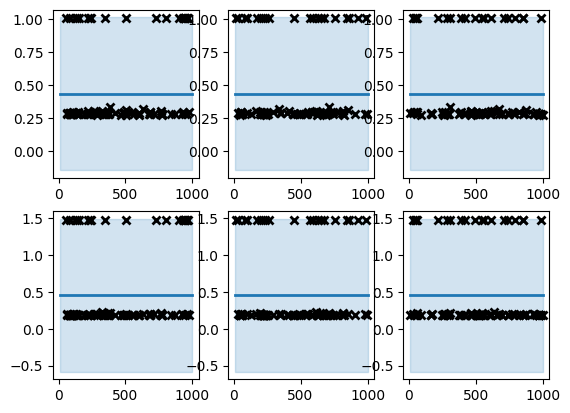

x_best =  [277.36218899 261.17687059 899.51634991]
acq_best =  [0.11484195 0.20616868]
C = [277, 261, 0.44975817495309883]
Epoch 1/6
517/517 [==============================] - 2s 2ms/step - loss: 57974669312.0000 - mae: 228960.9219 - mse: 128901488640.0000 - val_loss: 43373834240.0000 - val_mae: 203001.0312 - val_mse: 96437624832.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 32255539200.0000 - mae: 171407.7656 - mse: 71717142528.0000 - val_loss: 25794334720.0000 - val_mae: 155486.4062 - val_mse: 57351233536.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 27061016576.0000 - mae: 162347.8594 - mse: 60167540736.0000 - val_loss: 24659134464.0000 - val_mae: 160098.0938 - val_mse: 54827188224.0000
Epoch 4/6
517/517 [==============================] - 1s 3ms/step - loss: 26296379392.0000 - mae: 161101.5938 - mse: 58467422208.0000 - val_loss: 24403826688.0000 - val_mae: 153376.5000 - val_mse: 54259552256.0000
Epoch 5/6
517/517 [=====

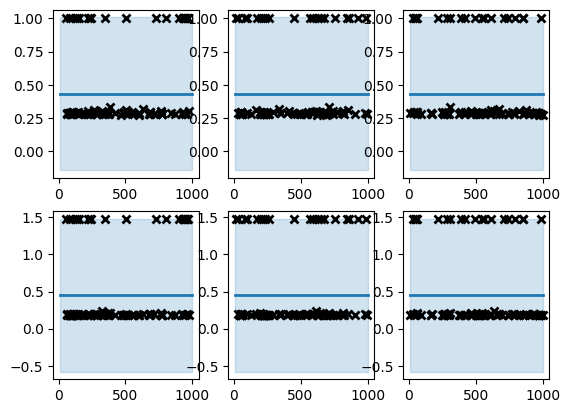

x_best =  [932.26480775 566.41571599 680.51848426]
acq_best =  [0.11438667 0.20534716]
C = [932, 566, 0.3402592421280034]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 35945820160.0000 - mae: 205400.7812 - mse: 105641902080.0000 - val_loss: 21686558720.0000 - val_mae: 165426.8906 - val_mse: 63734919168.0000
Epoch 2/6
517/517 [==============================] - 3s 5ms/step - loss: 20398524416.0000 - mae: 162320.2031 - mse: 59949494272.0000 - val_loss: 21174947840.0000 - val_mae: 168160.7500 - val_mse: 62231289856.0000
Epoch 3/6
517/517 [==============================] - 3s 6ms/step - loss: 20127592448.0000 - mae: 161615.8281 - mse: 59153199104.0000 - val_loss: 19955439616.0000 - val_mae: 171256.1562 - val_mse: 58647240704.0000
Epoch 4/6
517/517 [==============================] - 3s 6ms/step - loss: 19358072832.0000 - mae: 158420.9844 - mse: 56891678720.0000 - val_loss: 18586638336.0000 - val_mae: 159077.0312 - val_mse: 54624464896.0000
Epoch 5/6
517/517 [======

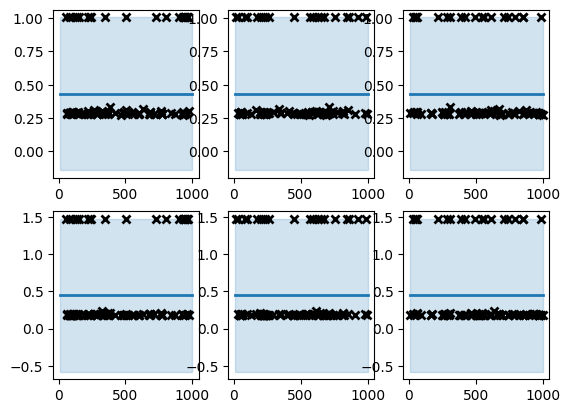

x_best =  [295.12836158 253.62821087 739.99549115]
acq_best =  [0.11395402 0.20453508]
C = [295, 254, 0.3699977455747044]
Epoch 1/6
517/517 [==============================] - 2s 3ms/step - loss: 156524576768.0000 - mae: 538371.5625 - mse: 423040581632.0000 - val_loss: 159115476992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 2/6
517/517 [==============================] - 1s 2ms/step - loss: 156524609536.0000 - mae: 538371.5000 - mse: 423040679936.0000 - val_loss: 159115476992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 3/6
517/517 [==============================] - 1s 2ms/step - loss: 156524625920.0000 - mae: 538371.6250 - mse: 423040581632.0000 - val_loss: 159115476992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 4/6
517/517 [==============================] - 1s 2ms/step - loss: 156524609536.0000 - mae: 538371.8750 - mse: 423040745472.0000 - val_loss: 159115476992.0000 - val_mae: 542668.6250 - val_mse: 430042939392.0000
Epoch 5/6


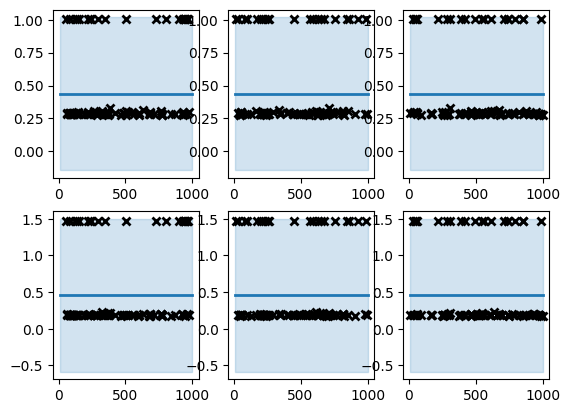

x_best =  [925.14855399 351.14678432 463.03979257]
acq_best =  [0.11574162 0.20774731]
C = [925, 352, 0.23151989628716207]
Epoch 1/6
517/517 [==============================] - 3s 5ms/step - loss: 26120591360.0000 - mae: 211206.2031 - mse: 112821280768.0000 - val_loss: 15318602752.0000 - val_mae: 163295.5000 - val_mse: 66164695040.0000
Epoch 2/6
517/517 [==============================] - 2s 5ms/step - loss: 14144525312.0000 - mae: 163136.4062 - mse: 61093507072.0000 - val_loss: 12618092544.0000 - val_mae: 152348.5469 - val_mse: 54500454400.0000
Epoch 3/6
517/517 [==============================] - 2s 5ms/step - loss: 13623024640.0000 - mae: 160355.4219 - mse: 58841042944.0000 - val_loss: 12755721216.0000 - val_mae: 160556.4375 - val_mse: 55094870016.0000
Epoch 4/6
482/517 [==========================>...] - ETA: 0s - loss: 13940482048.0000 - mae: 161310.4219 - mse: 60212150272.0000

In [ ]:
savename = "MOONNHouses"

### GPs Initialization
GP = GaussianProcess(O, C, d, lowerBounds, upperBounds, noise_variance=2e-6)

#### Initial samples, at least 1
for l in range(initial_iter):
    ## Get random evaluation point
    while True:
        x_rand = np.random.uniform(lowerBounds[0], upperBounds[0], d)
        if GP.X is None or not x_rand in GP.X:
            break
    ## EVALUATION OF THE OUTSIDE FUNCTION
    
    y_rand = evaluation(x_rand)
    GP.X = np.array([x_rand], dtype=float)
    GP.Y = np.array([y_rand], dtype=float)    
    
GP.updateGP()
GP.optimizeKernel()

if False:
    GP.plotSamples()

for l in range(total_iter):

    ## For all acq functions but usemo
    #x_best, acq_best = mesmo_acq(GP)
    ## For usemo
    x_best, acq_best = usemo_acq(GP, function = "ei", showplots = False)
    print("x_best = ", x_best)
    print("acq_best = ", acq_best)
    ## EVALUATION OF THE OUTSIDE FUNCTION
    y_best = evaluation(x_best)

    ## UPDATE
    GP.addSample(x_best,y_best)     ## Add new sample to the model
    GP.updateGP()                   ## Update data on the GP regressor
    GP.optimizeKernel()             ## Optimize kernel hyperparameters

    print("Iteration=", l, " x_best=", x_best, "y=", y_best)
    GP.plot()
    

## Evaluate results

As you are doing a real world experiment you do not have access to the real pareto front, then you do not have your metrics as before (I removed them).

What you should evaluate is the results in terms of the best *y* possible. You have the data below, but you may do a pandas dataframe to store it cleaner when it is computed in the previous section.

GP.X === samples where the function was evaluated

GP.Y === results of those evaluations

In [ ]:
GP.X, GP.Y

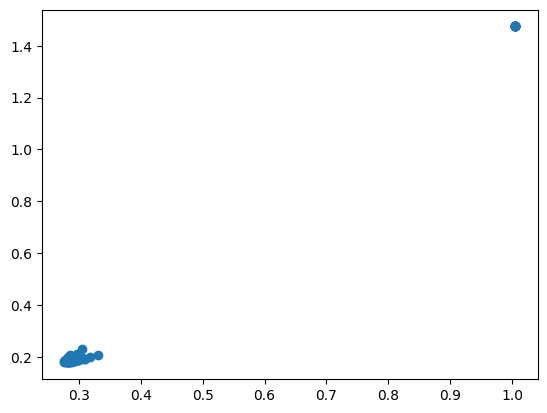

In [11]:
plt.scatter(GP.Y[:,0],GP.Y[:,1])

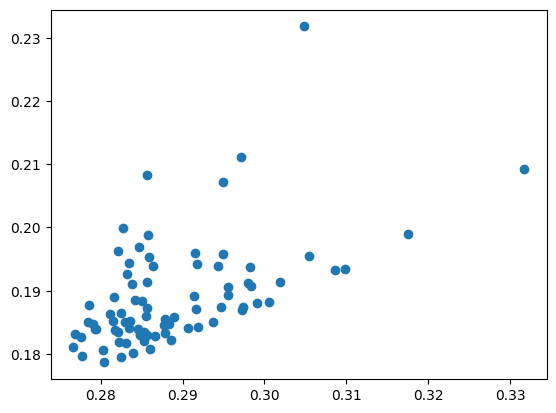

In [13]:
results = np.array([x for x in GP.Y if x[0]< 0.9])

plt.scatter(results[:,0],results[:,1])

In [14]:
results

array([[0.29066786, 0.18411608],
       [0.28393781, 0.1801554 ],
       [0.27945957, 0.18396637],
       [0.28895065, 0.18579207],
       [0.28839853, 0.18473145],
       [0.28558496, 0.18595065],
       [0.28791225, 0.18546259],
       [0.28313416, 0.18179743],
       [0.2834897 , 0.19441821],
       [0.28385869, 0.19099973],
       [0.28228208, 0.18194838],
       [0.28504321, 0.18840651],
       [0.28252003, 0.18648565],
       [0.29192969, 0.18427637],
       [0.29822043, 0.19373953],
       [0.28530681, 0.18348128],
       [0.2776964 , 0.17969808],
       [0.28458878, 0.18400767],
       [0.29139936, 0.18914089],
       [0.28567895, 0.18721983],
       [0.27859119, 0.18769857],
       [0.28415477, 0.18856512],
       [0.28525546, 0.1821025 ],
       [0.29492936, 0.20717698],
       [0.3054966 , 0.19554171],
       [0.28785712, 0.18335049],
       [0.28562185, 0.20831986],
       [0.29433423, 0.19386448],
       [0.28779432, 0.18456665],
       [0.2857002 , 0.19133443],
       [0.

In [ ]:
results = []
for c in np.linspace(0,0.1,100):
    results.append([c, MOOnnHousesRegression(c)])
    


In [ ]:
evs = [row[0] for row in results if row[1][0] < 500000]
mae = [row[1][0] for row in GP.Y if row[1][0] < 500000]
mse = [row[1][1] for row in results if row[1][0] < 500000]
plt.scatter(mae, mse)

In [ ]:
plt.scatter(evs, mae)

In [ ]:
mae

In [ ]:
results

In [ ]:
MOOnnHousesRegression(0)